In [189]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 400
pd.options.display.max_colwidth = 4000

In [190]:


#actions = pd.read_json("/Users/remim/dev/cdtn/cdtn-monolog/weeks_1-4_2020.json")
actions = pd.read_json("/Users/remim/tmp/all-january.json")

In [3]:
#actions = pd.read_json("/Users/remim/dev/cdtn/cdtn-monolog/2weeks.json")


In [4]:
#actions = pd.read_json("/Users/remim/tmp/logs-1912.json")
#actions = pd.read_json("/Users/remim/data/cdtn-logs/daily/2019-12-19-log.json")

# Check visits and action per date : assert no issues during collection

In [191]:
actions_dates = actions.drop_duplicates(subset=['idVisit'])['timestamp'].apply(lambda x : x.strftime("%d/%m/%y"))

In [192]:
# we retrieve the sorted dates
import datetime
dates = [datetime.datetime.strptime(ts, "%d/%m/%y") for ts in actions_dates.unique()]
dates.sort()
sorteddates = [datetime.datetime.strftime(ts, "%d/%m/%y") for ts in dates]

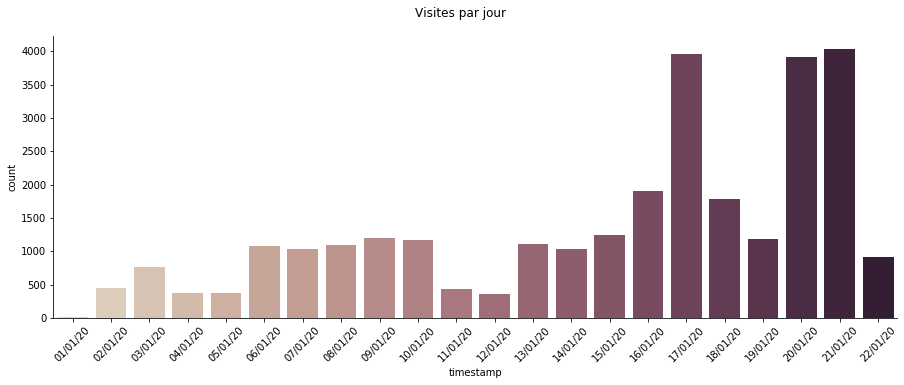

In [196]:
plot = sns.catplot(x="timestamp", kind="count", palette="ch:.25", aspect=25.7/10.27, data=pd.DataFrame(actions_dates), order=sorteddates);
plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Visites par jour")
#plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
#[sns.setp(ax.get_xticklabels(), rotation=45) for ax in plot.axes.flat]
for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Most popular contents

In [195]:
actions[actions.type == 'visit_content'][actions.url.apply(lambda x : x.startswith("https://code.travail.gouv.fr/"))]["url"]\
.apply(lambda x : x.split("gouv.fr/")[1])\
.value_counts()[:70]


/Users/remim/dev/cdtn/.python-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


outils/simulateur-embauche                                                                                                       6423
outils/indemnite-licenciement                                                                                                    3451
outils/preavis-demission                                                                                                         3393
droit-du-travail                                                                                                                 2746
glossaire                                                                                                                        1718
modeles-de-courriers/demande-de-paiement-de-salaire                                                                              1429
convention-collective/1486-bureaux-detudes-techniques-cabinets-dingenieurs-conseils-et-societes-de                               1304
fiche-ministere-travail/les-conges-payes                      

# Datafiller : generer variantes pour ajout aux suggestions

In [ ]:
# import json
# with open('request.datafiller-1712.json') as fd:
#      df_reqs_json = json.load(fd)

In [4]:
# titles_col = []
# variant_col = []
# is_title = []
# to_keep = []

# for entry in df_reqs_json['data']:
#     title = entry['title']
    
#     # first we add the title
#     titles_col.append(title)
#     variant_col.append(title)
#     is_title.append(True)

#     # then we add the variants
#     variants = entry['variants'].split('\n') if 'variants' in entry else []
#     for variant in variants :
#         titles_col.append(title)
#         variant_col.append(variant)
#         is_title.append(False)

# to_keep = np.ones([len(titles_col)], dtype=bool)        
# weight = [5] * len(titles_col)
         
# df_reqs_df = pd.DataFrame({'Candidat':variant_col, 'Entrée':titles_col, 'Titre':is_title, 'Conserver':to_keep, 'Poids': weight})

In [197]:
#df_reqs_df.to_excel("df_suggestion_qualification.xlsx")
#df_reqs_df.to_csv("df_suggestion_qualification-1712.csv")

# Rank and scoring

In [198]:
result_candidates_actions = actions[actions.type == "result_candidates"]
result_candidates_actions['documents'] = result_candidates_actions.result_candidates.apply(lambda x : x['documents'])

/Users/remim/dev/cdtn/.python-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [199]:
unique_search_visit = result_candidates_actions.idVisit.unique()

In [200]:
#one_visit = unique_search_visit[0]
#actions[actions.idVisit == 125978]

In [201]:
# for each visit that contain candidates actions
# we want to associate candidates and select result

# check if selection in previous candidates
def in_candidates(select_action, candidates):
    selected_url = select_action.res_selection['url']
    candidate_urls = [c['slug'] for c in candidates['documents']]
    
    if selected_url in candidate_urls:
        return (True, candidate_urls.index(selected_url))
    else :
        # elif : here we can be in different cases :
        # query undefined : theme results
        # selection resultat code du travail ou theme
        return (False, -1)

def analyze_visit(id_visit) :
    visit = actions[actions.idVisit == id_visit]

    last_candidates = {}
    last_query = ''
    consumed = False
    
    logs = []

    for _, action in visit.iterrows():
        if action.type == 'result_candidates':
            if last_candidates != action.result_candidates and last_query != action.query:
                last_candidates = action.result_candidates
                last_query = action.query
                consumed = False

        if (action.type == 'select_result'):
            
            # case no current candidates and selection
            if not(last_candidates):
                print('Selection before candidates ' + str(id_visit))
                continue;
            
#             selection = action.res_selection['url']
#             split = selection.split("/");
#             transformed = split[1].replace('-', "_").replace("fiche", "fiches") + "/" + split[2];                        
    
            (found, index) = in_candidates(action, last_candidates)
    
            if not found:
                print('Selection not in candidates ' + str(id_visit))
                #print(action.res_selection)
                #print([c['slug'] for c in last_candidates['documents']])
                
            # we keep track of the fact that candidates were "consumed"
            if index >= 0:  
                consumed = True
                
            logs.append({
                'docs_res': last_candidates['documents'],
                'articles_res': last_candidates['articles'],
                'themes_res': last_candidates['themes'],
                'idVisit': id_visit,
                'rank': index,
                'selection': action.res_selection['url'],
                'query': last_query
            })
                                

    if not consumed :
        print("Not consumed " + str(id_visit))
        logs.append({
                    'docs_res': last_candidates['documents'],
                    'articles_res': last_candidates['articles'],
                    'themes_res': last_candidates['themes'],
                    'idVisit': id_visit,
                    'rank': -2,
                    'selection': np.NaN,
                    'query': last_query
                })
        
    return logs


In [202]:
logs = []
for i in unique_search_visit:
    print(i)
    logs += analyze_visit(i)

130944
Not consumed 130944
130969
Not consumed 130969
130939
Not consumed 130939
130947
Selection before candidates 130947
Selection before candidates 130947
Selection not in candidates 130947
Not consumed 130947
130964
130578
Selection not in candidates 130578
Selection not in candidates 130578
Selection not in candidates 130578
Selection not in candidates 130578
130933
130460
Selection not in candidates 130460
130848
130918
Selection not in candidates 130918
Not consumed 130918
130938
130949
Not consumed 130949
130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in candidates 130642
Selection not in ca

129825
129858
129853
Not consumed 129853
129771
Selection not in candidates 129771
Selection not in candidates 129771
Selection not in candidates 129771
Not consumed 129771
129776
Selection before candidates 129776
Selection before candidates 129776
Selection before candidates 129776
Selection before candidates 129776
Selection not in candidates 129776
Not consumed 129776
129464
Selection before candidates 129464
Selection not in candidates 129464
Selection not in candidates 129464
Selection not in candidates 129464
129534
Selection before candidates 129534
Selection not in candidates 129534
Selection not in candidates 129534
Selection not in candidates 129534
Selection not in candidates 129534
Selection not in candidates 129534
Selection not in candidates 129534
Selection not in candidates 129534
129809
Selection not in candidates 129809
129831
Selection before candidates 129831
Selection before candidates 129831
Selection before candidates 129831
Selection before candidates 129831
Se

129302
Not consumed 129302
129470
Not consumed 129470
129497
Selection not in candidates 129497
Selection not in candidates 129497
Not consumed 129497
129521
Selection not in candidates 129521
Not consumed 129521
129517
129519
129476
Selection not in candidates 129476
Selection not in candidates 129476
Selection not in candidates 129476
Not consumed 129476
129046
Selection not in candidates 129046
Selection not in candidates 129046
Selection not in candidates 129046
Selection not in candidates 129046
Not consumed 129046
129369
Selection not in candidates 129369
Selection not in candidates 129369
Selection not in candidates 129369
Selection not in candidates 129369
129507
Not consumed 129507
129511
129512
Not consumed 129512
129503
129426
Selection not in candidates 129426
129446
Selection not in candidates 129446
Selection not in candidates 129446
Not consumed 129446
129485
Selection not in candidates 129485
Selection not in candidates 129485
129223
Selection not in candidates 129223
1

Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
Selection not in candidates 126302
129118
129105
Selection before candidates 129105
Selection before candidates 129105
Selection not in candidates 129105
Selection not in candidates 129105
Not consumed 129105
129158
Not consumed 129158
129122
Not consumed 129122
129130
128837
Selection not in candid

Selection not in candidates 130682
Selection not in candidates 130682
130651
Selection not in candidates 130651
Selection not in candidates 130651
Not consumed 130651
130639
128782
Selection not in candidates 128782
Selection not in candidates 128782
Selection not in candidates 128782
Selection not in candidates 128782
Not consumed 128782
128685
Selection not in candidates 128685
Selection not in candidates 128685
Selection not in candidates 128685
Selection not in candidates 128685
Selection not in candidates 128685
Selection not in candidates 128685
Selection not in candidates 128685
Not consumed 128685
128793
128772
Selection not in candidates 128772
128708
128794
Selection not in candidates 128794
Selection not in candidates 128794
Selection not in candidates 128794
Selection not in candidates 128794
Selection not in candidates 128794
Selection not in candidates 128794
Selection not in candidates 128794
Selection not in candidates 128794
Selection not in candidates 128794
128534
Se

Selection not in candidates 128485
Not consumed 128485
128528
128512
128452
128525
Not consumed 128525
128518
128482
128498
Selection not in candidates 128498
Not consumed 128498
128446
Selection not in candidates 128446
128499
Selection not in candidates 128499
Not consumed 128499
128493
Not consumed 128493
128456
Selection not in candidates 128456
Selection not in candidates 128456
Not consumed 128456
128454
Selection not in candidates 128454
Not consumed 128454
128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418
Selection not in candidates 128418

Not consumed 127005
128054
128201
Selection not in candidates 128201
Selection not in candidates 128201
Not consumed 128201
128057
Selection before candidates 128057
Selection before candidates 128057
Selection not in candidates 128057
Not consumed 128057
128194
Selection not in candidates 128194
Not consumed 128194
127976
Selection not in candidates 127976
Selection not in candidates 127976
Selection not in candidates 127976
Selection not in candidates 127976
Not consumed 127976
128150
128192
Not consumed 128192
128142
128190
127999
Not consumed 127999
128187
Not consumed 128187
127969
Selection not in candidates 127969
Selection not in candidates 127969
128179
Selection not in candidates 128179
Not consumed 128179
128156
Selection not in candidates 128156
128148
Selection before candidates 128148
Selection before candidates 128148
Selection not in candidates 128148
Selection not in candidates 128148
Selection not in candidates 128148
Selection not in candidates 128148
Selection not i

127697
Selection before candidates 127697
Not consumed 127697
127873
Selection not in candidates 127873
Selection not in candidates 127873
Selection not in candidates 127873
127849
Selection before candidates 127849
Not consumed 127849
127799
Selection not in candidates 127799
Selection not in candidates 127799
Selection not in candidates 127799
Selection not in candidates 127799
Selection not in candidates 127799
Selection not in candidates 127799
Selection not in candidates 127799
Selection not in candidates 127799
Selection not in candidates 127799
Selection not in candidates 127799
Selection not in candidates 127799
Selection not in candidates 127799
Selection not in candidates 127799
127870
127880
Selection not in candidates 127880
Not consumed 127880
127876
127874
Not consumed 127874
127757
Not consumed 127757
127854
Not consumed 127854
127867
Not consumed 127867
127842
Not consumed 127842
127812
Not consumed 127812
127837
Not consumed 127837
127851
Selection not in candidates 12

Not consumed 127548
127585
127561
127234
Not consumed 127234
127269
Selection not in candidates 127269
Selection not in candidates 127269
127505
Selection not in candidates 127505
Selection not in candidates 127505
Not consumed 127505
127579
127577
127574
127552
Selection before candidates 127552
Not consumed 127552
127292
Selection not in candidates 127292
Selection not in candidates 127292
Selection not in candidates 127292
Selection not in candidates 127292
127472
Selection before candidates 127472
Selection not in candidates 127472
Not consumed 127472
127438
Selection not in candidates 127438
Selection not in candidates 127438
Selection not in candidates 127438
Selection not in candidates 127438
Selection not in candidates 127438
Selection not in candidates 127438
Selection not in candidates 127438
Selection not in candidates 127438
Selection not in candidates 127438
Selection not in candidates 127438
Selection not in candidates 127438
Selection not in candidates 127438
Selection n

127236
Selection not in candidates 127236
Not consumed 127236
127241
126331
Selection before candidates 126331
Selection not in candidates 126331
Selection not in candidates 126331
Selection not in candidates 126331
127224
127237
127196
127212
Selection not in candidates 127212
Not consumed 127212
127048
127149
Selection not in candidates 127149
Not consumed 127149
127213
127211
127090
Not consumed 127090
127200
Selection not in candidates 127200
Selection not in candidates 127200
Not consumed 127200
127202
Selection not in candidates 127202
Selection not in candidates 127202
Selection not in candidates 127202
Selection not in candidates 127202
Not consumed 127202
126409
Selection not in candidates 126409
127176
127192
Selection not in candidates 127192
Not consumed 127192
127094
Selection not in candidates 127094
Selection not in candidates 127094
Not consumed 127094
127181
Not consumed 127181
127170
Selection not in candidates 127170
Selection not in candidates 127170
Not consumed 12

Not consumed 126840
126339
Selection not in candidates 126339
Not consumed 126339
126816
Not consumed 126816
126808
Selection not in candidates 126808
126634
126793
Selection not in candidates 126793
Selection not in candidates 126793
Selection not in candidates 126793
Selection not in candidates 126793
Selection not in candidates 126793
Not consumed 126793
126819
126826
Not consumed 126826
126704
Selection before candidates 126704
Selection before candidates 126704
Selection before candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Selection not in candidates 126704
Not 

Not consumed 130558
130542
Selection not in candidates 130542
Not consumed 130542
130549
Not consumed 130549
130548
Selection not in candidates 130548
130404
Selection not in candidates 130404
130547
Not consumed 130547
130539
Selection not in candidates 130539
Selection not in candidates 130539
Selection not in candidates 130539
130537
Not consumed 130537
130535
Not consumed 130535
130526
Selection before candidates 130526
130482
Not consumed 130482
130517
Selection before candidates 130517
Selection before candidates 130517
Selection before candidates 130517
130393
Selection not in candidates 130393
Selection not in candidates 130393
Selection not in candidates 130393
Selection not in candidates 130393
Selection not in candidates 130393
Selection not in candidates 130393
Selection not in candidates 130393
Not consumed 130393
130495
Not consumed 130495
130522
130516
Selection not in candidates 130516
Selection not in candidates 130516
Selection not in candidates 130516
Not consumed 13

Not consumed 126176
125935
125969
Selection not in candidates 125969
Selection not in candidates 125969
Not consumed 125969
125971
125927
Not consumed 125927
126187
Selection not in candidates 126187
Selection not in candidates 126187
126213
Selection not in candidates 126213
Selection not in candidates 126213
Not consumed 126213
126239
Not consumed 126239
126235
Selection before candidates 126235
Not consumed 126235
125998
126227
Not consumed 126227
126188
Selection not in candidates 126188
Selection not in candidates 126188
Selection not in candidates 126188
Selection not in candidates 126188
Selection not in candidates 126188
Selection not in candidates 126188
Not consumed 126188
126226
Selection not in candidates 126226
126210
126219
Not consumed 126219
126215
Selection not in candidates 126215
125888
Selection not in candidates 125888
Selection not in candidates 125888
Not consumed 125888
126183
126191
Selection not in candidates 126191
Selection not in candidates 126191
125943
No

Selection not in candidates 124938
Not consumed 124938
124742
Selection not in candidates 124742
Not consumed 124742
124934
Selection before candidates 124934
124832
Selection not in candidates 124832
Not consumed 124832
124944
124941
Selection not in candidates 124941
Not consumed 124941
124830
Selection not in candidates 124830
Not consumed 124830
124889
Not consumed 124889
124581
Selection not in candidates 124581
Selection not in candidates 124581
Selection not in candidates 124581
Selection not in candidates 124581
Not consumed 124581
124936
Not consumed 124936
124762
124933
124940
124920
Selection not in candidates 124920
Selection not in candidates 124920
Selection not in candidates 124920
Not consumed 124920
124778
Selection not in candidates 124778
Selection not in candidates 124778
Selection not in candidates 124778
Selection not in candidates 124778
Selection not in candidates 124778
Selection not in candidates 124778
Selection not in candidates 124778
Selection not in candi

Selection not in candidates 124534
Selection not in candidates 124534
Not consumed 124534
124597
Not consumed 124597
124591
Not consumed 124591
124582
Selection before candidates 124582
Not consumed 124582
124562
Selection not in candidates 124562
Not consumed 124562
124583
Not consumed 124583
124563
Not consumed 124563
124385
124565
Not consumed 124565
124301
Selection not in candidates 124301
Selection not in candidates 124301
Selection not in candidates 124301
124570
Not consumed 124570
124571
Not consumed 124571
124521
Not consumed 124521
124557
124461
Selection not in candidates 124461
Selection not in candidates 124461
Not consumed 124461
124554
124436
Selection before candidates 124436
Selection not in candidates 124436
124446
124538
Selection not in candidates 124538
Not consumed 124538
124542
124188
Selection before candidates 124188
Selection before candidates 124188
Selection before candidates 124188
Selection before candidates 124188
Selection before candidates 124188
Selec

Selection not in candidates 124016
Selection not in candidates 124016
124187
Selection before candidates 124187
Selection before candidates 124187
Selection before candidates 124187
Selection not in candidates 124187
Selection not in candidates 124187
Not consumed 124187
126057
Not consumed 126057
126079
Selection before candidates 126079
Selection not in candidates 126079
Selection not in candidates 126079
Not consumed 126079
126074
125918
Selection before candidates 125918
126059
Selection before candidates 126059
Not consumed 126059
126053
Selection not in candidates 126053
Not consumed 126053
125801
126038
Not consumed 126038
126042
Selection not in candidates 126042
126039
Selection before candidates 126039
126049
Selection before candidates 126049
Not consumed 126049
126045
126002
Selection not in candidates 126002
Selection not in candidates 126002
Selection not in candidates 126002
Not consumed 126002
125976
Selection before candidates 125976
Selection not in candidates 125976


Selection not in candidates 123564
Not consumed 123564
123732
Not consumed 123732
123907
Not consumed 123907
123897
123900
Selection not in candidates 123900
Not consumed 123900
123888
Selection not in candidates 123888
Not consumed 123888
123778
Not consumed 123778
123878
Selection not in candidates 123878
Selection not in candidates 123878
Selection not in candidates 123878
Not consumed 123878
123858
Selection not in candidates 123858
123193
Selection not in candidates 123193
Selection not in candidates 123193
Selection not in candidates 123193
Not consumed 123193
123472
Not consumed 123472
123885
123872
Selection not in candidates 123872
Not consumed 123872
123881
123824
123864
123870
Not consumed 123870
123850
Not consumed 123850
123857
Selection not in candidates 123857
Selection not in candidates 123857
Not consumed 123857
123855
123818
Selection not in candidates 123818
123859
123620
Selection not in candidates 123620
123801
123846
Selection not in candidates 123846
123410
Selec

Selection not in candidates 123291
Selection not in candidates 123291
Selection not in candidates 123291
Selection not in candidates 123291
Selection not in candidates 123291
Selection not in candidates 123291
Not consumed 123291
123530
Not consumed 123530
123166
Selection not in candidates 123166
Selection not in candidates 123166
Selection not in candidates 123166
Not consumed 123166
122760
Selection not in candidates 122760
123477
Selection not in candidates 123477
Selection not in candidates 123477
123480
123511
Selection not in candidates 123511
Not consumed 123511
123519
123502
123424
Selection not in candidates 123424
Selection not in candidates 123424
Selection not in candidates 123424
Selection not in candidates 123424
Selection not in candidates 123424
Selection not in candidates 123424
Selection not in candidates 123424
Selection not in candidates 123424
Selection not in candidates 123424
Selection not in candidates 123424
Selection not in candidates 123424
Selection not in 

Not consumed 123097
123049
Not consumed 123049
122873
Selection not in candidates 122873
Selection not in candidates 122873
Selection not in candidates 122873
Selection not in candidates 122873
Selection not in candidates 122873
Selection not in candidates 122873
Selection not in candidates 122873
Selection not in candidates 122873
Selection not in candidates 122873
Selection not in candidates 122873
Selection not in candidates 122873
Selection not in candidates 122873
122987
Selection not in candidates 122987
Not consumed 122987
123131
123140
Not consumed 123140
123211
Selection not in candidates 123211
Selection not in candidates 123211
Selection not in candidates 123211
Selection not in candidates 123211
Selection not in candidates 123211
Selection not in candidates 123211
Selection not in candidates 123211
Selection not in candidates 123211
Selection not in candidates 123211
Selection not in candidates 123211
Not consumed 123211
122824
123003
Not consumed 123003
122113
Selection no

Selection not in candidates 122043
Selection not in candidates 122043
Not consumed 122043
122447
Selection not in candidates 122447
Selection not in candidates 122447
Selection not in candidates 122447
123033
Not consumed 123033
122988
Not consumed 122988
123014
123011
Selection not in candidates 123011
Not consumed 123011
123019
Not consumed 123019
122874
Selection before candidates 122874
Not consumed 122874
122957
123010
122701
Selection not in candidates 122701
Selection not in candidates 122701
Selection not in candidates 122701
Not consumed 122701
125858
Not consumed 125858
125721
Selection not in candidates 125721
Not consumed 125721
125937
Selection not in candidates 125937
Not consumed 125937
125866
125854
Not consumed 125854
125845
125872
Selection not in candidates 125872
Not consumed 125872
125925
Not consumed 125925
125933
125940
Not consumed 125940
125861
125897
125899
125842
Not consumed 125842
125846
Not consumed 125846
125813
125881
Not consumed 125881
125879
Not consu

Selection not in candidates 122610
Selection not in candidates 122610
122287
Selection not in candidates 122287
Selection not in candidates 122287
Selection not in candidates 122287
Selection not in candidates 122287
Selection not in candidates 122287
Not consumed 122287
122516
Not consumed 122516
122560
122567
Not consumed 122567
122508
Selection not in candidates 122508
Selection not in candidates 122508
Not consumed 122508
122403
Not consumed 122403
122587
Not consumed 122587
122555
122452
122472
Selection not in candidates 122472
Selection not in candidates 122472
Selection not in candidates 122472
Not consumed 122472
122577
122573
Not consumed 122573
122570
Not consumed 122570
122233
Selection before candidates 122233
Selection not in candidates 122233
122426
Selection not in candidates 122426
Not consumed 122426
122532
122151
Selection not in candidates 122151
Selection not in candidates 122151
Selection not in candidates 122151
Selection not in candidates 122151
Not consumed 122

Selection not in candidates 121611
Selection not in candidates 121611
Selection not in candidates 121611
Selection not in candidates 121611
Selection not in candidates 121611
Selection not in candidates 121611
Selection not in candidates 121611
122372
Not consumed 122372
122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in candidates 122256
Selection not in cand

122107
122204
Not consumed 122204
121832
Selection not in candidates 121832
Selection not in candidates 121832
Not consumed 121832
122056
122085
122185
121810
122160
122024
122192
122165
Not consumed 122165
122148
122139
121933
Not consumed 121933
122162
122172
122163
Not consumed 122163
122149
Not consumed 122149
121800
Selection before candidates 121800
Not consumed 121800
121725
Selection not in candidates 121725
Selection not in candidates 121725
Selection not in candidates 121725
Selection not in candidates 121725
Not consumed 121725
122141
122137
122144
122054
121358
Selection not in candidates 121358
Selection not in candidates 121358
Selection not in candidates 121358
Selection not in candidates 121358
Selection not in candidates 121358
Not consumed 121358
122081
121895
122131
122134
Not consumed 122134
122130
Not consumed 122130
122028
Selection not in candidates 122028
Selection not in candidates 122028
Selection not in candidates 122028
Not consumed 122028
122119
122123
Sele

Selection not in candidates 121197
Selection not in candidates 121197
Selection not in candidates 121197
Selection not in candidates 121197
Selection not in candidates 121197
Selection not in candidates 121197
121940
Selection not in candidates 121940
Not consumed 121940
121944
Selection not in candidates 121944
Selection not in candidates 121944
Selection not in candidates 121944
Selection not in candidates 121944
Not consumed 121944
121952
121929
121900
Selection not in candidates 121900
Not consumed 121900
121916
121905
Not consumed 121905
121245
Selection not in candidates 121245
Selection not in candidates 121245
Selection not in candidates 121245
Not consumed 121245
121938
Not consumed 121938
121659
Selection not in candidates 121659
Selection not in candidates 121659
121948
Selection before candidates 121948
Not consumed 121948
121943
Not consumed 121943
121592
Selection not in candidates 121592
Selection not in candidates 121592
121853
121931
Selection not in candidates 121931


Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Selection not in candidates 121399
Not consumed 121399
121709
121591
Not consumed 121591
121665
121702
121692
Selection not in candidates 121692
Not consumed 121692
121689
121687
Not consumed 121687
121632
Not consumed 121632
121584
121618
Not consumed 121618
12167

Not consumed 125644
125710
125661
Selection not in candidates 125661
125421
125692
125684
Selection not in candidates 125684
Not consumed 125684
125576
Not consumed 125576
125687
Not consumed 125687
125608
125594
Not consumed 125594
125561
Not consumed 125561
125659
Not consumed 125659
125655
Selection not in candidates 125655
125649
125647
Not consumed 125647
125382
Selection not in candidates 125382
Selection not in candidates 125382
Selection not in candidates 125382
Selection not in candidates 125382
Selection not in candidates 125382
Selection not in candidates 125382
Selection not in candidates 125382
Selection not in candidates 125382
Selection not in candidates 125382
Not consumed 125382
125637
Not consumed 125637
125631
Selection not in candidates 125631
Not consumed 125631
125582
Selection before candidates 125582
Not consumed 125582
125543
Selection not in candidates 125543
Selection not in candidates 125543
Selection not in candidates 125543
Not consumed 125543
125600
12561

Not consumed 120995
120974
Not consumed 120974
121173
Not consumed 121173
120726
Selection not in candidates 120726
Selection not in candidates 120726
Selection not in candidates 120726
Selection not in candidates 120726
Not consumed 120726
120740
Selection not in candidates 120740
Selection not in candidates 120740
Not consumed 120740
121170
Not consumed 121170
120951
Selection not in candidates 120951
120927
Selection not in candidates 120927
Selection not in candidates 120927
121154
121140
121130
Not consumed 121130
120933
Selection before candidates 120933
Not consumed 120933
121152
Not consumed 121152
121090
121158
120989
Selection not in candidates 120989
Selection not in candidates 120989
121034
Selection not in candidates 121034
121151
Not consumed 121151
121014
Selection before candidates 121014
Selection not in candidates 121014
Selection not in candidates 121014
Selection not in candidates 121014
Not consumed 121014
121099
121159
121160
121094
Not consumed 121094
121027
1208

119781
Selection not in candidates 119781
Selection not in candidates 119781
Selection not in candidates 119781
Selection not in candidates 119781
Selection not in candidates 119781
Selection not in candidates 119781
Selection not in candidates 119781
Selection not in candidates 119781
119833
119841
119829
Selection not in candidates 119829
119796
119817
Selection not in candidates 119817
Not consumed 119817
119815
119811
Selection before candidates 119811
Not consumed 119811
119788
Selection not in candidates 119788
Selection not in candidates 119788
Not consumed 119788
119803
119799
119587
Selection not in candidates 119587
Selection not in candidates 119587
Selection not in candidates 119587
Selection not in candidates 119587
Selection not in candidates 119587
Selection not in candidates 119587
Selection not in candidates 119587
Selection not in candidates 119587
Selection not in candidates 119587
Not consumed 119587
119760
Not consumed 119760
119800
Not consumed 119800
119584
Selec

Not consumed 120719
120766
120750
Selection not in candidates 120750
120751
Not consumed 120751
120778
120749
Selection not in candidates 120749
Not consumed 120749
120768
Not consumed 120768
120761
120743
Not consumed 120743
120785
Not consumed 120785
120762
120776
120774
Not consumed 120774
120745
Not consumed 120745
120772
Not consumed 120772
120754
120757
120770
Not consumed 120770
120746
120742
Not consumed 120742
120727
Selection not in candidates 120727
120736
120734
Not consumed 120734
120728
120722
120724
120714
120713
120709
120706
Not consumed 120706
120703
Not consumed 120703
120697
120701
Not consumed 120701
120684
Not consumed 120684
120685
Not consumed 120685
120683
120681
120672
120675
Not consumed 120675
120667
Not consumed 120667
120664
Not consumed 120664
120663
120656
120511
Selection not in candidates 120511
Selection not in candidates 120511
Selection not in candidates 120511
Selection not in candidates 120511
Selection not in candidates 120511
Selection not in ca

Not consumed 120413
120407
120372
120362
Not consumed 120362
120314
Selection not in candidates 120314
Not consumed 120314
120382
Selection not in candidates 120382
120358
Selection not in candidates 120358
Not consumed 120358
120369
Not consumed 120369
120403
Not consumed 120403
120365
Selection before candidates 120365
Not consumed 120365
120398
120397
Not consumed 120397
120376
Selection not in candidates 120376
Not consumed 120376
120391
120371
Not consumed 120371
120385
120357
120381
120383
120379
Selection not in candidates 120379
120378
Not consumed 120378
120380
Not consumed 120380
120346
Not consumed 120346
120366
Not consumed 120366
120348
120337
Selection not in candidates 120337
Not consumed 120337
120352
120076
Selection not in candidates 120076
Selection not in candidates 120076
Selection not in candidates 120076
Selection not in candidates 120076
Selection not in candidates 120076
Selection not in candidates 120076
Selection not in candidates 120076
Selection not in cand

Selection not in candidates 119513
Selection not in candidates 119513
Selection not in candidates 119513
119547
Not consumed 119547
119495
Selection not in candidates 119495
Selection not in candidates 119495
Selection not in candidates 119495
Not consumed 119495
119525
119526
Not consumed 119526
119528
Not consumed 119528
119539
Not consumed 119539
119529
Not consumed 119529
119532
119527
119514
Selection not in candidates 119514
Selection not in candidates 119514
119520
Not consumed 119520
119517
119446
Selection not in candidates 119446
Selection not in candidates 119446
Selection not in candidates 119446
Selection not in candidates 119446
Selection not in candidates 119446
Selection not in candidates 119446
Selection not in candidates 119446
Selection not in candidates 119446
Not consumed 119446
119458
Selection before candidates 119458
Selection not in candidates 119458
119506
Not consumed 119506
119502
Not consumed 119502
119496
Selection not in candidates 119496
Selection not in

118454
Not consumed 118454
118432
Selection not in candidates 118432
Selection not in candidates 118432
Selection not in candidates 118432
Not consumed 118432
118462
Not consumed 118462
118444
Selection before candidates 118444
Selection before candidates 118444
Selection before candidates 118444
118442
Selection not in candidates 118442
Selection not in candidates 118442
Not consumed 118442
118201
Selection not in candidates 118201
Not consumed 118201
118359
Selection not in candidates 118359
Selection not in candidates 118359
118398
Not consumed 118398
118349
Selection not in candidates 118349
118441
Selection not in candidates 118441
Selection not in candidates 118441
Selection not in candidates 118441
Not consumed 118441
118439
Selection not in candidates 118439
118162
Not consumed 118162
118346
Not consumed 118346
118443
Not consumed 118443
118437
118403
Selection before candidates 118403
Selection before candidates 118403
Selection not in candidates 118403
118362
118420
118321
No

Selection not in candidates 117945
117973
Selection not in candidates 117973
Selection not in candidates 117973
Selection not in candidates 117973
Selection not in candidates 117973
Not consumed 117973
117951
118008
Not consumed 118008
117995
Not consumed 117995
117927
Selection not in candidates 117927
Not consumed 117927
117976
Selection not in candidates 117976
117940
Selection not in candidates 117940
Not consumed 117940
117996
117999
Not consumed 117999
117992
117904
117923
Not consumed 117923
117911
Selection not in candidates 117911
Selection not in candidates 117911
Selection not in candidates 117911
Selection not in candidates 117911
Selection not in candidates 117911
Selection not in candidates 117911
Selection not in candidates 117911
Selection not in candidates 117911
Not consumed 117911
117983
Selection before candidates 117983
Not consumed 117983
117978
Not consumed 117978
117979
Not consumed 117979
117862
Selection before candidates 117862
Selection before candidates 117

Not consumed 119209
119161
119205
Not consumed 119205
119128
Selection not in candidates 119128
Not consumed 119128
118357
Selection not in candidates 118357
Selection not in candidates 118357
Selection not in candidates 118357
Selection not in candidates 118357
Selection not in candidates 118357
Selection not in candidates 118357
Selection not in candidates 118357
Selection not in candidates 118357
Selection not in candidates 118357
Selection not in candidates 118357
Selection not in candidates 118357
Selection not in candidates 118357
Selection not in candidates 118357
119178
Selection not in candidates 119178
Selection not in candidates 119178
Selection not in candidates 119178
Not consumed 119178
119197
Not consumed 119197
119196
Selection not in candidates 119196
Not consumed 119196
119199
Selection before candidates 119199
Not consumed 119199
119190
119181
119189
119106
Selection before candidates 119106
Selection before candidates 119106
Not consumed 119106
119149
Selection befo

Selection before candidates 118978
118890
Selection not in candidates 118890
Selection not in candidates 118890
117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
Selection not in candidates 117946
118953
118816
Selection not in candidates 118816
118947
Selection not in candidates 118947
118952
118759
Selection before candidates 118759
Selection before candidates 118759
118904
Selection not in candidates 118904

118523
Selection not in candidates 118523
Selection not in candidates 118523
118700
Not consumed 118700
118698
118701
Not consumed 118701
118539
Selection not in candidates 118539
Selection not in candidates 118539
Selection not in candidates 118539
118693
118655
Selection not in candidates 118655
Selection not in candidates 118655
118689
Not consumed 118689
118691
Not consumed 118691
118686
Not consumed 118686
118485
Selection not in candidates 118485
118660
118665
118683
Not consumed 118683
118672
Selection not in candidates 118672
Not consumed 118672
118625
Selection before candidates 118625
118534
Selection not in candidates 118534
Not consumed 118534
118663
Not consumed 118663
117885
Selection not in candidates 117885
Selection not in candidates 117885
Selection not in candidates 117885
Selection not in candidates 117885
Selection not in candidates 117885
Selection not in candidates 117885
Selection not in candidates 117885
Selection not in candidates 117885
Selection not in candi

Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
Selection not in candidates 117683
117626
Selection not in candidates 117626
Selection not in candidates 117626
Selection not in candidates 117626
Selection not in candidates 117626
Selection not in candidates 117626
Selection not in candidates 117626
Selection not in candidates 117626
Selection not in candidates 117626
Selection not in candidates 117626
Selection not in candidates 117626
Selection not in candidates 117626
117833
Not co

Selection not in candidates 115719
Selection not in candidates 115719
Selection not in candidates 115719
Selection not in candidates 115719
Selection not in candidates 115719
Selection not in candidates 115719
Selection not in candidates 115719
Selection not in candidates 115719
Not consumed 115719
116761
116583
Selection not in candidates 116583
116565
Not consumed 116565
116667
Selection not in candidates 116667
Selection not in candidates 116667
Selection not in candidates 116667
Not consumed 116667
116747
116759
Not consumed 116759
116729
Selection not in candidates 116729
Selection not in candidates 116729
116569
Not consumed 116569
116731
Selection not in candidates 116731
Selection not in candidates 116731
116724
Selection not in candidates 116724
Not consumed 116724
116736
Selection not in candidates 116736
Selection not in candidates 116736
Not consumed 116736
116322
Selection not in candidates 116322
Selection not in candidates 116322
Selection not in candidates 116322
Select

Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
Selection not in candidates 115998
116304
Selection not in candidates 116304
Selection not in candidates 116304
Not consumed 116304
116449
Selection not in candidates 116449
Not consumed 116449
116514
116432
Selection not in candidates 116432
116400
Selection not in candidates 116400
Selection not in candidates 116400
Not consumed 116400
116493
116397
Selection not in candidates 116397
Not consumed 116397
116500
Selection not in candidates 116500
Not consumed 116500
116362
114705
Selection not in candidates 114705
Selection not in candidat

Selection not in candidates 115144
Not consumed 115144
116197
Not consumed 116197
116245
116108
116232
Not consumed 116232
116255
Not consumed 116255
116235
116184
Selection not in candidates 116184
Selection not in candidates 116184
Selection not in candidates 116184
Not consumed 116184
116106
116089
116159
116204
116216
116217
Not consumed 116217
116215
116176
116161
Selection not in candidates 116161
Selection not in candidates 116161
116194
Not consumed 116194
116188
Selection not in candidates 116188
116200
Not consumed 116200
115921
115611
Not consumed 115611
116193
Not consumed 116193
116173
Not consumed 116173
116156
116171
Not consumed 116171
115892
Selection not in candidates 115892
Selection not in candidates 115892
Selection not in candidates 115892
Selection not in candidates 115892
Selection not in candidates 115892
Selection not in candidates 115892
Selection not in candidates 115892
Not consumed 115892
116168
116148
Not consumed 116148
116068
Not consumed 116068
116098


115838
Selection not in candidates 115838
Not consumed 115838
115068
Selection not in candidates 115068
Selection not in candidates 115068
Selection not in candidates 115068
Selection not in candidates 115068
Selection not in candidates 115068
Selection not in candidates 115068
Selection not in candidates 115068
114489
Selection before candidates 114489
Selection before candidates 114489
Selection not in candidates 114489
Not consumed 114489
115841
Not consumed 115841
115788
115792
115728
115793
Not consumed 115793
115825
115665
Selection before candidates 115665
Selection before candidates 115665
Not consumed 115665
115740
115809
115818
115578
Selection not in candidates 115578
115813
Not consumed 115813
115786
115490
Not consumed 115490
115790
115770
115716
115738
Selection not in candidates 115738
Selection not in candidates 115738
Selection not in candidates 115738
Selection not in candidates 115738
Selection not in candidates 115738
Selection not in candidates 115738
115685
Select

Selection not in candidates 115489
Selection not in candidates 115489
115497
115439
Selection before candidates 115439
Not consumed 115439
114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
Selection not in candidates 114537
115612
115605
Not consumed 115605
115472
Not consumed 115472
115536
Not consumed 115536
115482
Selection not in candidates 115482
115596
115564
115608
115378
115504
Not consumed 115504
114783
Selection not in candidates 1147

Selection not in candidates 115026
Selection not in candidates 115026
Selection not in candidates 115026
Selection not in candidates 115026
Selection not in candidates 115026
Selection not in candidates 115026
Selection not in candidates 115026
Selection not in candidates 115026
Selection not in candidates 115026
Selection not in candidates 115026
Selection not in candidates 115026
Not consumed 115026
115352
Not consumed 115352
115331
Not consumed 115331
115333
Not consumed 115333
115202
Selection not in candidates 115202
Not consumed 115202
115274
Not consumed 115274
115169
115328
Not consumed 115328
115232
Selection not in candidates 115232
Selection not in candidates 115232
Selection not in candidates 115232
Selection not in candidates 115232
Selection not in candidates 115232
Not consumed 115232
115141
Selection before candidates 115141
Selection not in candidates 115141
Selection not in candidates 115141
Not consumed 115141
115207
115285
Selection not in candidates 115285
Not cons

Not consumed 114943
114958
114966
Not consumed 114966
114494
Selection not in candidates 114494
Not consumed 114494
114930
114932
114672
114559
Selection not in candidates 114559
Not consumed 114559
114127
Selection not in candidates 114127
Not consumed 114127
114842
114922
Not consumed 114922
114548
Selection not in candidates 114548
114698
Not consumed 114698
114827
Selection not in candidates 114827
Not consumed 114827
114895
114909
Selection not in candidates 114909
114898
Not consumed 114898
114903
114891
114904
Not consumed 114904
114886
Not consumed 114886
114901
Not consumed 114901
114767
114025
Selection not in candidates 114025
114831
Not consumed 114831
114900
Not consumed 114900
114815
Selection not in candidates 114815
Selection not in candidates 114815
Selection not in candidates 114815
Selection not in candidates 114815
Selection not in candidates 114815
Selection not in candidates 114815
Selection not in candidates 114815
Selection not in candidates 114815
Selection not

Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Selection not in candidates 113846
Not consumed 113846
114474
Selection before candidates 114474
114551
114578
Selection not in candidates 114578
Not consumed 114578
114582
114581
Selection not in candidates 114581
114366
Not consumed 114366
114573
114432
Selection not in candidates 114432
Not consumed 114432
114456
Selection not in candidates 114456
Selection not in candidates 114456
Selection not in candidates 114456
Selection not in candidates 114456
Selection not in candidates 114456
Selection not in 

Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Selection not in candidates 117011
Not consumed 117011
117518
117517
Not consumed 117517
117255
Selection not in candidates 117255
Selection not in candidates 117255
Selection not in candidates 117255
Selection not in candidates 117255
Selection not in candidates 117255
Selection not in candidates 117255
Selection not in candidates 117255
Selection not in candidates 117255
Selection not in candidates 117255
Selection not in candidates 1

114355
Not consumed 114355
114161
114169
Not consumed 114169
114383
Not consumed 114383
114318
114378
Not consumed 114378
114377
114367
Not consumed 114367
114186
114163
114363
114321
114348
114235
Not consumed 114235
114286
Not consumed 114286
113982
114335
Selection not in candidates 114335
Selection not in candidates 114335
Not consumed 114335
114280
Not consumed 114280
113861
Selection not in candidates 113861
Not consumed 113861
114229
Selection not in candidates 114229
Selection not in candidates 114229
114123
Selection not in candidates 114123
Selection not in candidates 114123
Selection not in candidates 114123
Selection not in candidates 114123
Selection not in candidates 114123
Selection not in candidates 114123
Selection not in candidates 114123
Selection not in candidates 114123
Selection not in candidates 114123
Selection not in candidates 114123
Selection not in candidates 114123
Selection not in candidates 114123
Selection not in candidates 114123
Not consumed 114123
114

Selection before candidates 113857
Selection before candidates 113857
Selection before candidates 113857
114013
Not consumed 114013
114003
Selection before candidates 114003
Selection before candidates 114003
113937
113869
Selection before candidates 113869
113829
Selection not in candidates 113829
Selection not in candidates 113829
Selection not in candidates 113829
Selection not in candidates 113829
Selection not in candidates 113829
Not consumed 113829
113935
113860
Selection before candidates 113860
Not consumed 113860
114023
114004
113899
Not consumed 113899
113927
114010
Not consumed 114010
113970
Selection not in candidates 113970
Selection not in candidates 113970
Not consumed 113970
113917
113936
Selection before candidates 113936
113988
Not consumed 113988
113933
Selection not in candidates 113933
Selection not in candidates 113933
113944
Selection before candidates 113944
113913
113947
Not consumed 113947
113965
113844
Selection before candidates 113844
Selection not in cand

Not consumed 117311
117322
Not consumed 117322
117305
Not consumed 117305
117295
Not consumed 117295
117275
Selection not in candidates 117275
117286
Selection not in candidates 117286
Not consumed 117286
117287
Not consumed 117287
117284
116955
Selection before candidates 116955
Selection not in candidates 116955
Selection not in candidates 116955
Selection not in candidates 116955
Selection not in candidates 116955
Selection not in candidates 116955
Selection not in candidates 116955
Selection not in candidates 116955
117136
Selection before candidates 117136
Selection before candidates 117136
Selection not in candidates 117136
Selection not in candidates 117136
Not consumed 117136
117137
Selection before candidates 117137
Selection not in candidates 117137
Selection not in candidates 117137
Selection not in candidates 117137
Selection not in candidates 117137
Selection not in candidates 117137
Selection not in candidates 117137
Selection not in candidates 117137
Selection not in can

117082
Not consumed 117082
117039
Selection not in candidates 117039
Not consumed 117039
117076
Selection not in candidates 117076
Not consumed 117076
117072
117071
117017
Not consumed 117017
117004
Selection not in candidates 117004
116681
Selection not in candidates 116681
Selection not in candidates 116681
116950
Not consumed 116950
117061
Not consumed 117061
116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 116489
Selection not in candidates 11648

Selection not in candidates 116813
Selection not in candidates 116813
Selection not in candidates 116813
Selection not in candidates 116813
Selection not in candidates 116813
Selection not in candidates 116813
Selection not in candidates 116813
Selection not in candidates 116813
Selection not in candidates 116813
Selection not in candidates 116813
Selection not in candidates 116813
Selection not in candidates 116813
116925
Not consumed 116925
116901
Selection before candidates 116901
116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Selection not in candidates 116788
Not consumed 1

Not consumed 113624
113739
Selection not in candidates 113739
Selection not in candidates 113739
Selection not in candidates 113739
Selection not in candidates 113739
Selection not in candidates 113739
Not consumed 113739
113812
Selection not in candidates 113812
113123
Selection before candidates 113123
Selection not in candidates 113123
Selection not in candidates 113123
Selection not in candidates 113123
Selection not in candidates 113123
Selection not in candidates 113123
Selection not in candidates 113123
Selection not in candidates 113123
Selection not in candidates 113123
Selection not in candidates 113123
Selection not in candidates 113123
Not consumed 113123
113301
Selection not in candidates 113301
Selection not in candidates 113301
Selection not in candidates 113301
Selection not in candidates 113301
Selection not in candidates 113301
Not consumed 113301
113823
Not consumed 113823
113072
Selection not in candidates 113072
Selection not in candidates 113072
113451
113825
Not 

Selection not in candidates 112678
Selection not in candidates 112678
Selection not in candidates 112678
Selection not in candidates 112678
Selection not in candidates 112678
Selection not in candidates 112678
Selection not in candidates 112678
Selection not in candidates 112678
Selection not in candidates 112678
Selection not in candidates 112678
Not consumed 112678
113479
113684
Not consumed 113684
113135
Selection not in candidates 113135
Selection not in candidates 113135
Selection not in candidates 113135
Selection not in candidates 113135
Not consumed 113135
113760
Not consumed 113760
113381
Selection not in candidates 113381
113145
Selection not in candidates 113145
Selection not in candidates 113145
Selection not in candidates 113145
Selection not in candidates 113145
Selection not in candidates 113145
Not consumed 113145
113769
113633
Selection not in candidates 113633
113751
113113
Selection not in candidates 113113
Selection not in candidates 113113
Selection not in candidat

Not consumed 112337
112745
112663
112729
112604
112728
Not consumed 112728
112443
Selection not in candidates 112443
Not consumed 112443
112722
112727
Not consumed 112727
112642
Selection not in candidates 112642
112690
Selection not in candidates 112690
Not consumed 112690
112719
112693
Not consumed 112693
112711
112708
112701
Selection before candidates 112701
Not consumed 112701
112576
Selection not in candidates 112576
Selection not in candidates 112576
Selection not in candidates 112576
Selection not in candidates 112576
Selection not in candidates 112576
Not consumed 112576
112707
112206
Selection not in candidates 112206
Selection not in candidates 112206
Selection not in candidates 112206
Selection not in candidates 112206
Selection not in candidates 112206
Selection not in candidates 112206
Selection not in candidates 112206
Selection not in candidates 112206
Selection not in candidates 112206
Selection not in candidates 112206
Selection not in candidates 112206
Selection not 

112360
112359
Selection before candidates 112359
112307
Selection not in candidates 112307
Selection not in candidates 112307
Not consumed 112307
112313
112321
Not consumed 112321
112334
Not consumed 112334
112343
Not consumed 112343
112336
Not consumed 112336
112338
Not consumed 112338
112279
Selection not in candidates 112279
Not consumed 112279
112291
Selection before candidates 112291
112303
112328
Not consumed 112328
112085
Selection not in candidates 112085
Selection not in candidates 112085
Selection not in candidates 112085
Selection not in candidates 112085
Selection not in candidates 112085
Selection not in candidates 112085
Selection not in candidates 112085
Selection not in candidates 112085
Selection not in candidates 112085
Selection not in candidates 112085
Selection not in candidates 112085
112209
Selection not in candidates 112209
Selection not in candidates 112209
Selection not in candidates 112209
Selection not in candidates 112209
Selection not in candidates 112209


Selection not in candidates 111787
Selection not in candidates 111787
Selection not in candidates 111787
Selection not in candidates 111787
111904
111894
111906
Not consumed 111906
111867
Selection not in candidates 111867
Selection not in candidates 111867
Selection not in candidates 111867
Not consumed 111867
111579
111864
111880
Selection not in candidates 111880
Not consumed 111880
111847
Selection not in candidates 111847
Selection not in candidates 111847
Selection not in candidates 111847
111872
Not consumed 111872
111863
Selection before candidates 111863
Not consumed 111863
111875
Not consumed 111875
111823
Not consumed 111823
111856
Selection not in candidates 111856
Selection not in candidates 111856
Selection not in candidates 111856
Not consumed 111856
111821
Selection not in candidates 111821
Selection not in candidates 111821
Selection not in candidates 111821
Selection not in candidates 111821
Selection not in candidates 111821
Selection not in candidates 111821
111678


113155
Selection before candidates 113155
Selection before candidates 113155
Selection not in candidates 113155
Selection not in candidates 113155
113352
Selection not in candidates 113352
Not consumed 113352
113545
Selection not in candidates 113545
Selection not in candidates 113545
Selection not in candidates 113545
Not consumed 113545
113491
Selection not in candidates 113491
Selection not in candidates 113491
Selection not in candidates 113491
Selection not in candidates 113491
Selection not in candidates 113491
Selection not in candidates 113491
Selection not in candidates 113491
Selection not in candidates 113491
Selection not in candidates 113491
Selection not in candidates 113491
Selection not in candidates 113491
Not consumed 113491
113367
Selection before candidates 113367
113566
Selection not in candidates 113566
Selection not in candidates 113566
Selection not in candidates 113566
Selection not in candidates 113566
Selection not in candidates 113566
Not consumed 113566
113

Not consumed 110760
110848
110887
110762
Selection not in candidates 110762
Selection not in candidates 110762
Selection not in candidates 110762
Selection not in candidates 110762
Selection not in candidates 110762
Selection not in candidates 110762
Selection not in candidates 110762
Not consumed 110762
110878
110863
Not consumed 110863
110846
Not consumed 110846
110827
Not consumed 110827
110867
Not consumed 110867
110864
110599
Selection before candidates 110599
Selection not in candidates 110599
110849
Selection before candidates 110849
Not consumed 110849
110840
110855
Selection before candidates 110855
Not consumed 110855
110856
Not consumed 110856
110852
110845
Selection not in candidates 110845
Selection not in candidates 110845
Selection not in candidates 110845
Selection not in candidates 110845
110843
110833
110830
Selection not in candidates 110830
Not consumed 110830
110773
110797
Not consumed 110797
110803
110816
110724
Not consumed 110724
110806
110730
110792
110777
Not 

Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Selection not in candidates 113112
Not consumed 113112
113290
Selection not in candidates 113290
113345
Selection not in candidates 113345
113351
112959
Selection not in candidates 112959
Selection not in candidates 112959
Selection not in candidates 112959
Selection not in candidates 112959
Selection not in candidates 112959
Selection not in candidates 112959
Selection not in candidates 112959
Selection not in candidates 112959
Selection not in candidates 112959
Selection not in candidates 112959
Selecti

Selection not in candidates 112419
Selection not in candidates 112419
Selection not in candidates 112419
Selection not in candidates 112419
Selection not in candidates 112419
Selection not in candidates 112419
Not consumed 112419
112936
112985
112986
Selection not in candidates 112986
Not consumed 112986
112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Selection not in candidates 112798
Not consumed 112798
112963
Selection not in candidates 11

Selection not in candidates 112391
Selection not in candidates 112391
112845
112857
112662
Selection before candidates 112662
Selection before candidates 112662
Selection before candidates 112662
Selection not in candidates 112662
112859
112828
Not consumed 112828
112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Selection not in candidates 112310
Not consumed 112310
112796
Selection not in candidates 112796
Selection not in candidates 112796
Selection not in candidates 112796
Selection not in candidates 112796
Selection not in candidates 112796
112851
Selection not in candidates 1

Not consumed 110329
110412
110414
110411
110404
110343
Selection not in candidates 110343
Selection not in candidates 110343
Not consumed 110343
110400
110396
Selection not in candidates 110396
110332
Selection before candidates 110332
Selection not in candidates 110332
Selection not in candidates 110332
Selection not in candidates 110332
Selection not in candidates 110332
Selection not in candidates 110332
Selection not in candidates 110332
Selection not in candidates 110332
Selection not in candidates 110332
Selection not in candidates 110332
Selection not in candidates 110332
Not consumed 110332
110386
Selection not in candidates 110386
Selection not in candidates 110386
Selection not in candidates 110386
110391
110350
Not consumed 110350
110390
110377
Not consumed 110377
110353
Selection not in candidates 110353
Not consumed 110353
110365
Selection not in candidates 110365
Selection not in candidates 110365
Not consumed 110365
110345
Selection not in candidates 110345
Selection not

Not consumed 110050
110077
109972
Selection before candidates 109972
109973
110056
Not consumed 110056
109940
110049
110051
109879
Selection before candidates 109879
Selection before candidates 109879
Selection before candidates 109879
Selection not in candidates 109879
Selection not in candidates 109879
Selection not in candidates 109879
Selection not in candidates 109879
Selection not in candidates 109879
Selection not in candidates 109879
Selection not in candidates 109879
Selection not in candidates 109879
Selection not in candidates 109879
Selection not in candidates 109879
Selection not in candidates 109879
109522
Selection not in candidates 109522
Selection not in candidates 109522
Selection not in candidates 109522
Selection not in candidates 109522
Selection not in candidates 109522
Selection not in candidates 109522
Selection not in candidates 109522
Selection not in candidates 109522
Selection not in candidates 109522
Selection not in candidates 109522
Selection not in candi

109854
Selection before candidates 109854
109068
Selection not in candidates 109068
Selection not in candidates 109068
109842
Not consumed 109842
109808
109839
Selection not in candidates 109839
Not consumed 109839
109844
109195
Selection before candidates 109195
109711
Selection not in candidates 109711
Selection not in candidates 109711
Selection not in candidates 109711
Selection not in candidates 109711
Selection not in candidates 109711
Not consumed 109711
109717
Selection not in candidates 109717
Selection not in candidates 109717
Selection not in candidates 109717
Selection not in candidates 109717
Not consumed 109717
109234
Selection not in candidates 109234
Selection not in candidates 109234
109812
Not consumed 109812
109690
Selection before candidates 109690
Not consumed 109690
109695
109735
Not consumed 109735
109701
109464
109240
Selection not in candidates 109240
Not consumed 109240
109765
109757
Selection not in candidates 109757
Selection not in candidates 109757
Not con

Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Selection not in candidates 108810
Not consumed 108810
109150
Not consumed 109150
108520
108443
Selection before candidates 108443
Selection before candidates 108443
108518
Selection not in candidates 108518
Not consumed 108518
108498
108495
108524
Not consumed 108524
108415
Selection not in candidates 108415
Selection not in candidates 108415
Not consumed 108415
108469
108439
Not consumed 108439
108468
Not consumed 108468
108510
Not consumed 108510
108441
108478
108508


Not consumed 107929
107927
107912
Selection not in candidates 107912
Selection not in candidates 107912
Selection not in candidates 107912
Selection not in candidates 107912
107293
Selection not in candidates 107293
Selection not in candidates 107293
Not consumed 107293
107920
107919
107726
Not consumed 107726
107900
107906
Selection not in candidates 107906
107645
107777
107873
Selection before candidates 107873
107887
107717
Not consumed 107717
107874
107880
107753
107750
Selection before candidates 107750
Selection not in candidates 107750
107850
Selection not in candidates 107850
Selection not in candidates 107850
107791
Selection not in candidates 107791
Not consumed 107791
107496
Selection not in candidates 107496
Selection not in candidates 107496
Selection not in candidates 107496
Not consumed 107496
107444
Not consumed 107444
107752
Selection not in candidates 107752
Selection not in candidates 107752
Selection not in candidates 107752
Selection not in candidates 107752
Select

Not consumed 106612
106593
106585
106583
106579
Not consumed 106579
106555
106529
106553
106546
106547
106539
Not consumed 106539
106531
106536
106522
Selection not in candidates 106522
Not consumed 106522
106532
Not consumed 106532
106526
Selection not in candidates 106526
Not consumed 106526
106518
106509
Selection not in candidates 106509
106513
Not consumed 106513
106505
106503
Not consumed 106503
106502
Selection not in candidates 106502
Not consumed 106502
106496
Selection not in candidates 106496
Selection not in candidates 106496
Not consumed 106496
106486
Not consumed 106486
106481
Not consumed 106481
106479
Selection not in candidates 106479
Not consumed 106479
106463
Not consumed 106463
106452
106453
Not consumed 106453
106448
106447
106446
106426
106390
106440
Not consumed 106440
106415
Not consumed 106415
106437
106436
Not consumed 106436
106399
Selection not in candidates 106399
Selection not in candidates 106399
Not consumed 106399
106387
Selection before candidates 1063

Selection not in candidates 105770
Selection not in candidates 105770
Selection not in candidates 105770
Selection not in candidates 105770
Selection not in candidates 105770
Selection not in candidates 105770
Selection not in candidates 105770
Selection not in candidates 105770
Selection not in candidates 105770
106068
106048
Not consumed 106048
105990
Not consumed 105990
106007
105868
105986
105620
Selection not in candidates 105620
Selection not in candidates 105620
Selection not in candidates 105620
106012
105975
Not consumed 105975
105969
Selection before candidates 105969
Selection before candidates 105969
Selection not in candidates 105969
Selection not in candidates 105969
Selection not in candidates 105969
Selection not in candidates 105969
105800
105697
Selection not in candidates 105697
Selection not in candidates 105697
Selection not in candidates 105697
Selection not in candidates 105697
Selection not in candidates 105697
Selection not in candidates 105697
Selection not in

105389
Not consumed 105389
105404
105390
105330
Not consumed 105330
105383
105252
Selection not in candidates 105252
Not consumed 105252
105307
Selection not in candidates 105307
Not consumed 105307
105394
Not consumed 105394
105372
Selection not in candidates 105372
Not consumed 105372
105284
105168
Not consumed 105168
105309
Not consumed 105309
105266
Selection not in candidates 105266
105357
105327
Not consumed 105327
105303
Not consumed 105303
105346
105337
105334
105318
Not consumed 105318
105317
105326
105211
Not consumed 105211
105322
Not consumed 105322
105302
Selection before candidates 105302
Selection not in candidates 105302
Selection not in candidates 105302
Selection not in candidates 105302
Selection not in candidates 105302
105281
Selection not in candidates 105281
Not consumed 105281
105312
105234
105300
105292
Not consumed 105292
105243
Selection not in candidates 105243
Selection not in candidates 105243
Selection not in candidates 105243
Selection not in candidates 

Selection not in candidates 103989
Selection not in candidates 103989
Selection not in candidates 103989
Selection not in candidates 103989
Not consumed 103989
103990
Not consumed 103990
103991
Selection not in candidates 103991
103999
Not consumed 103999
103993
Not consumed 103993
103984
Not consumed 103984
103946
Selection not in candidates 103946
Not consumed 103946
103961
Selection not in candidates 103961
Selection not in candidates 103961
Not consumed 103961
103963
103936
Not consumed 103936
103952
Not consumed 103952
103953
Not consumed 103953
103949
103947
Not consumed 103947
103939
103935
103934
Not consumed 103934
103937
103928
103930
Not consumed 103930
103925
Not consumed 103925
103866
Selection not in candidates 103866
Selection not in candidates 103866
Selection not in candidates 103866
Selection not in candidates 103866
Selection not in candidates 103866
Selection not in candidates 103866
Not consumed 103866
103920
Selection not in candidates 103920
Not consumed 103920
1

Selection before candidates 103216
Not consumed 103216
103218
102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
Selection not in candidates 102857
103214
Selection not in candidates 103214
Not consumed 103214
103119
Selection not in candidates 103119
Not consumed 103119
103144
Not consumed 103144
103170
103188
Selection not in candidates 103188
Not consumed 103188
103079
Selection before candidates 103079
Sele

Selection not in candidates 102550
102623
102383
Selection not in candidates 102383
102525
Not consumed 102525
102614
102545
Selection not in candidates 102545
Not consumed 102545
102499
Selection not in candidates 102499
Selection not in candidates 102499
Selection not in candidates 102499
Selection not in candidates 102499
Selection not in candidates 102499
Selection not in candidates 102499
Selection not in candidates 102499
Selection not in candidates 102499
Selection not in candidates 102499
Selection not in candidates 102499
Selection not in candidates 102499
Selection not in candidates 102499
Not consumed 102499
102455
Not consumed 102455
102577
Not consumed 102577
102602
Not consumed 102602
102601
Not consumed 102601
102592
Selection not in candidates 102592
Not consumed 102592
102588
102560
102530
Not consumed 102530
102583
Selection not in candidates 102583
Selection not in candidates 102583
Not consumed 102583
102452
102305
Selection not in candidates 102305
Selection not in

Not consumed 101958
101954
101926
101914
101941
Not consumed 101941
101927
Selection not in candidates 101927
Selection not in candidates 101927
Selection not in candidates 101927
Selection not in candidates 101927
Selection not in candidates 101927
101937
101938
Not consumed 101938
101935
Not consumed 101935
101930
101922
Not consumed 101922
101911
Selection not in candidates 101911
101915
Selection not in candidates 101915
Selection not in candidates 101915
Not consumed 101915
101910
101900
Not consumed 101900
101902
Selection not in candidates 101902
Selection not in candidates 101902
Not consumed 101902
101905
Selection not in candidates 101905
Not consumed 101905
101904
101901
Not consumed 101901
101896
101897
Not consumed 101897
101886
101887
101873
Not consumed 101873
101874
Not consumed 101874
101870
101862
101856
Selection not in candidates 101856
101848
Not consumed 101848
101841
101854
101855
101851
Not consumed 101851
101844
101819
Not consumed 101819
101839
Selection not i

101584
Selection not in candidates 101584
Not consumed 101584
101498
Selection not in candidates 101498
Selection not in candidates 101498
Selection not in candidates 101498
101589
Selection not in candidates 101589
Not consumed 101589
101585
Not consumed 101585
101583
Not consumed 101583
101578
Selection not in candidates 101578
Selection not in candidates 101578
Selection not in candidates 101578
Selection not in candidates 101578
Selection not in candidates 101578
101535
101508
Not consumed 101508
101573
101576
Selection not in candidates 101576
Not consumed 101576
101546
Selection before candidates 101546
Not consumed 101546
101555
101568
100929
Selection not in candidates 100929
Selection not in candidates 100929
Selection not in candidates 100929
Selection not in candidates 100929
Selection not in candidates 100929
Selection not in candidates 100929
Selection not in candidates 100929
Selection not in candidates 100929
Selection not in candidates 100929
Selection not in candidates

Selection not in candidates 100876
Not consumed 100876
101066
100832
Selection not in candidates 100832
Selection not in candidates 100832
100496
Selection not in candidates 100496
Selection not in candidates 100496
Selection not in candidates 100496
Selection not in candidates 100496
Selection not in candidates 100496
Selection not in candidates 100496
Selection not in candidates 100496
Selection not in candidates 100496
Selection not in candidates 100496
Selection not in candidates 100496
Not consumed 100496
100959
Not consumed 100959
101064
Not consumed 101064
101055
101062
100941
Selection not in candidates 100941
Not consumed 100941
100567
Selection not in candidates 100567
Selection not in candidates 100567
Not consumed 100567
101043
101046
Not consumed 101046
101011
Not consumed 101011
100888
Selection not in candidates 100888
Selection not in candidates 100888
100802
Selection not in candidates 100802
Selection not in candidates 100802
Selection not in candidates 100802
Not con

Not consumed 99706
99924
Selection not in candidates 99924
Not consumed 99924
99925
99904
99915
Not consumed 99915
99914
99911
Not consumed 99911
99891
Not consumed 99891
99889
99900
Not consumed 99900
99890
Not consumed 99890
99892
99874
Not consumed 99874
99861
Not consumed 99861
99883
Not consumed 99883
99881
99873
Not consumed 99873
99750
Not consumed 99750
99860
Not consumed 99860
99804
Selection not in candidates 99804
Not consumed 99804
99840
Selection not in candidates 99840
Selection not in candidates 99840
Selection not in candidates 99840
Selection not in candidates 99840
Selection not in candidates 99840
Selection not in candidates 99840
Selection not in candidates 99840
Not consumed 99840
99792
Not consumed 99792
99843
99856
Selection not in candidates 99856
99841
Not consumed 99841
99839
Selection not in candidates 99839
Selection not in candidates 99839
Not consumed 99839
99830
99822
99821
99817
99819
Not consumed 99819
99708
Not consumed 99708
99810
99803
99742
Not cons

Selection not in candidates 98917
Selection not in candidates 98917
Selection not in candidates 98917
Selection not in candidates 98917
Not consumed 98917
99242
Selection not in candidates 99242
Not consumed 99242
99202
Not consumed 99202
99212
98875
99213
Not consumed 99213
99102
Not consumed 99102
99186
99182
Not consumed 99182
99198
99041
Selection not in candidates 99041
Selection not in candidates 99041
Not consumed 99041
99172
99155
99043
Selection before candidates 99043
Selection not in candidates 99043
Selection not in candidates 99043
Not consumed 99043
99108
Selection not in candidates 99108
Not consumed 99108
98827
Not consumed 98827
99137
99104
Not consumed 99104
99139
Not consumed 99139
98725
Selection not in candidates 98725
Selection not in candidates 98725
Selection not in candidates 98725
Selection not in candidates 98725
99135
Not consumed 99135
98879
Selection before candidates 98879
Selection not in candidates 98879
Selection not in candidates 98879
Selection not i

98370
Selection not in candidates 98370
Selection not in candidates 98370
Selection not in candidates 98370
Not consumed 98370
98349
Selection not in candidates 98349
Selection not in candidates 98349
Not consumed 98349
98361
Not consumed 98361
98348
97025
Selection not in candidates 97025
Selection not in candidates 97025
Not consumed 97025
97086
97089
Not consumed 97089
96944
Selection not in candidates 96944
Not consumed 96944
97085
97028
Not consumed 97028
96970
96954
Not consumed 96954
97016
Not consumed 97016
97070
Not consumed 97070
97032
Selection not in candidates 97032
Not consumed 97032
96924
Selection not in candidates 96924
Selection not in candidates 96924
Selection not in candidates 96924
Selection not in candidates 96924
Selection not in candidates 96924
Selection not in candidates 96924
97049
Selection not in candidates 97049
Not consumed 97049
97040
Selection before candidates 97040
Not consumed 97040
97035
Not consumed 97035
96936
Not consumed 96936
97020
Selection n

Selection not in candidates 97492
Selection not in candidates 97492
Selection not in candidates 97492
Not consumed 97492
97903
97773
97792
Selection not in candidates 97792
Not consumed 97792
97854
97845
Not consumed 97845
97911
97910
97884
97840
97831
Selection not in candidates 97831
Not consumed 97831
97869
Not consumed 97869
97796
Selection not in candidates 97796
Selection not in candidates 97796
Not consumed 97796
97543
Selection before candidates 97543
Selection not in candidates 97543
Selection not in candidates 97543
Not consumed 97543
97769
97833
Not consumed 97833
97826
97594
Selection before candidates 97594
Selection not in candidates 97594
Selection not in candidates 97594
Selection not in candidates 97594
Selection not in candidates 97594
Selection not in candidates 97594
Selection not in candidates 97594
Selection not in candidates 97594
Selection not in candidates 97594
Selection not in candidates 97594
Selection not in candidates 97594
Selection not in candidates 9759

97271
97224
Selection not in candidates 97224
Not consumed 97224
97215
97214
Not consumed 97214
97260
97249
Not consumed 97249
97152
Not consumed 97152
97250
Not consumed 97250
97237
Not consumed 97237
96932
Selection before candidates 96932
Selection not in candidates 96932
Selection not in candidates 96932
Not consumed 96932
97130
97207
Not consumed 97207
97220
Not consumed 97220
96995
97118
97061
Selection not in candidates 97061
96968
Not consumed 96968
97090
Selection not in candidates 97090
96963
Selection not in candidates 96963
Selection not in candidates 96963
Selection not in candidates 96963
Not consumed 96963
97077
Not consumed 97077
97170
Not consumed 97170
97171
Not consumed 97171
97139
97168
97069
Selection not in candidates 97069
97166
Not consumed 97166
96991
Not consumed 96991
97054
Selection not in candidates 97054
Not consumed 97054
97079
Selection before candidates 97079
97159
Selection not in candidates 97159
Not consumed 97159
97057
Not consumed 97057
97153
Not c

Selection not in candidates 96085
Selection not in candidates 96085
Selection not in candidates 96085
Selection not in candidates 96085
Selection not in candidates 96085
Selection not in candidates 96085
Selection not in candidates 96085
Selection not in candidates 96085
Not consumed 96085
96148
Selection not in candidates 96148
Selection not in candidates 96148
Selection not in candidates 96148
Selection not in candidates 96148
Not consumed 96148
96449
Selection before candidates 96449
Not consumed 96449
96454
95243
Selection before candidates 95243
Selection before candidates 95243
Selection not in candidates 95243
Selection not in candidates 95243
Selection not in candidates 95243
Selection not in candidates 95243
Selection not in candidates 95243
Selection not in candidates 95243
Selection not in candidates 95243
Selection not in candidates 95243
Selection not in candidates 95243
Selection not in candidates 95243
Selection not in candidates 95243
Selection not in candidates 95243
S

Not consumed 95663
95790
Not consumed 95790
95844
Selection before candidates 95844
95824
Not consumed 95824
95864
95816
Not consumed 95816
95863
95851
Not consumed 95851
95840
95850
Selection not in candidates 95850
Not consumed 95850
95653
Selection not in candidates 95653
Selection not in candidates 95653
Selection not in candidates 95653
Selection not in candidates 95653
Selection not in candidates 95653
Selection not in candidates 95653
Selection not in candidates 95653
Selection not in candidates 95653
Selection not in candidates 95653
95652
Selection before candidates 95652
Selection not in candidates 95652
95827
95773
95772
Selection not in candidates 95772
95811
Not consumed 95811
95809
Not consumed 95809
95788
Not consumed 95788
95802
Not consumed 95802
95792
95794
95783
95757
Selection not in candidates 95757
Not consumed 95757
95764
Selection not in candidates 95764
Not consumed 95764
95518
Not consumed 95518
95730
95758
Not consumed 95758
95754
95749
Selection not in candi

Selection not in candidates 95051
Selection not in candidates 95051
Selection not in candidates 95051
Selection not in candidates 95051
Selection not in candidates 95051
Selection not in candidates 95051
Selection not in candidates 95051
Selection not in candidates 95051
Not consumed 95051
95062
95009
Not consumed 95009
95059
Not consumed 95059
95054
Not consumed 95054
95026
Selection not in candidates 95026
Selection not in candidates 95026
Selection not in candidates 95026
Not consumed 95026
95013
Selection not in candidates 95013
Selection not in candidates 95013
Selection not in candidates 95013
95048
Selection not in candidates 95048
95046
Selection not in candidates 95046
Not consumed 95046
95049
Not consumed 95049
95043
95022
95030
Not consumed 95030
95024
Selection not in candidates 95024
Selection not in candidates 95024
Not consumed 95024
94981
Not consumed 94981
95020
95019
Selection not in candidates 95019
Not consumed 95019
95015
95012
Not consumed 95012
95010
94984
Not co

Not consumed 94055
94053
94050
94046
93989
94045
94041
94040
Not consumed 94040
94035
Selection not in candidates 94035
Not consumed 94035
94031
Not consumed 94031
93864
Selection not in candidates 93864
93930
Not consumed 93930
93984
Not consumed 93984
93980
Not consumed 93980
93956
Not consumed 93956
93465
Selection not in candidates 93465
Selection not in candidates 93465
Selection not in candidates 93465
Selection not in candidates 93465
Selection not in candidates 93465
Selection not in candidates 93465
Selection not in candidates 93465
Selection not in candidates 93465
Selection not in candidates 93465
Selection not in candidates 93465
Selection not in candidates 93465
Selection not in candidates 93465
Selection not in candidates 93465
Not consumed 93465
93964
94003
Not consumed 94003
94005
Not consumed 94005
94004
Not consumed 94004
94002
94000
Not consumed 94000
93991
Selection not in candidates 93991
Not consumed 93991
93992
Not consumed 93992
93990
Not consumed 93990
93981
No

Selection not in candidates 93325
Selection not in candidates 93325
Selection not in candidates 93325
Selection not in candidates 93325
Not consumed 93325
93411
Not consumed 93411
93383
93400
93336
Selection not in candidates 93336
Selection not in candidates 93336
Not consumed 93336
93370
Selection not in candidates 93370
Not consumed 93370
93376
93363
Not consumed 93363
93374
Not consumed 93374
93368
Not consumed 93368
93329
Selection not in candidates 93329
Selection not in candidates 93329
Not consumed 93329
93223
Selection not in candidates 93223
Selection not in candidates 93223
Selection not in candidates 93223
Selection not in candidates 93223
Not consumed 93223
93345
Selection not in candidates 93345
Not consumed 93345
93334
Not consumed 93334
93225
Not consumed 93225
93353
Selection not in candidates 93353
Not consumed 93353
93339
93340
Not consumed 93340
93338
Not consumed 93338
93275
93318
Selection before candidates 93318
Selection before candidates 93318
Selection before 

92796
92792
Selection not in candidates 92792
Not consumed 92792
92791
92771
92755
92445
Selection not in candidates 92445
Selection not in candidates 92445
Selection not in candidates 92445
Not consumed 92445
92768
Not consumed 92768
92766
Not consumed 92766
92587
Not consumed 92587
92756
92684
Selection not in candidates 92684
Selection not in candidates 92684
Selection not in candidates 92684
92752
92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Selection not in candidates 92492
Not consume

In [203]:
df_searches = pd.DataFrame(logs)

In [204]:
df_searches[df_searches['rank'] >= 0].shape[0] / df_searches.shape[0]

0.49629107126604166

In [205]:
def print_rangs(query):
    dem_queries = df_searches[(df_searches['query']==query) | (df_searches['query']==query)]
    only_pos = dem_queries[dem_queries['rank'] >=0]
    plot = sns.catplot(x="rank", kind="count", palette="ch:.25", data=pd.DataFrame(only_pos));
    plt.subplots_adjust(top=0.9)
    plot.fig.suptitle("Rangs pour la requête : " + query)

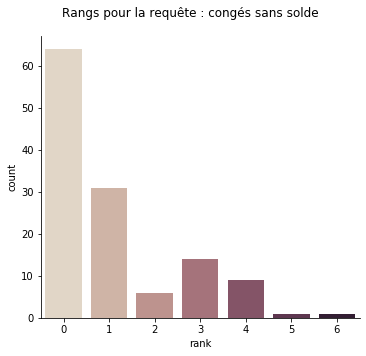

In [206]:
print_rangs('congés sans solde')

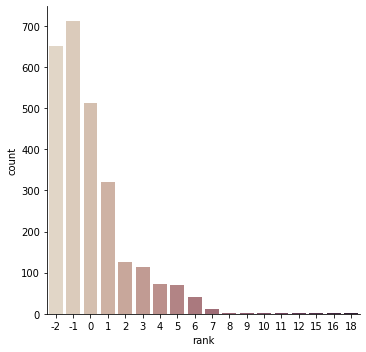

In [305]:
pd.Series(list(filter(lambda x : x >=0, pd.DataFrame(logs)['rank'].values.tolist()))).describe()
sns.catplot(x="rank", kind="count", palette="ch:.25", data=pd.DataFrame(logs));

In [293]:
actions[actions.idVisit == 67888]

,serverTimePretty,timeSpentPretty,lastActionTimestamp,referrerTypeName,url,referrerName,subtitle,timeSpent,type,@timestamp,...,timestamp,query,result_candidates,eventCategory,selection,eventAction,suggestion_candidates,prefix,feedback_type,visited
4813,"Nov 27, 2019 06:07:06",0s,1574864508,Direct Entry,https://code.travail.gouv.fr/,,"Event_Category: ""candidateSuggestions', Action...",0.0,suggestion_candidates,2019-11-27T06:07:06.000Z,...,2019-11-27 06:07:06,NaN,NaN,NaN,NaN,NaN,"[danger grave et imminent, danger grave ou imm...",NaN,NaN,NaN
4818,"Nov 27, 2019 06:07:18",1s,1574864508,Direct Entry,https://code.travail.gouv.fr/recherche,,"Event_Category: ""selectResult', Action: ""/fich...",1.0,select_result,2019-11-27T06:07:18.000Z,...,2019-11-27 06:07:18,NaN,NaN,selectResult,/fiche-ministere-travail/travail-sur-ecran#Que...,/fiche-ministere-travail/travail-sur-ecran#Que...,NaN,NaN,NaN,NaN
4822,"Nov 27, 2019 06:07:31",8s,1574864508,Direct Entry,,,NaN,8.0,search,2019-11-27T06:07:31.000Z,...,2019-11-27 06:07:31,danger grave et imminent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4827,"Nov 27, 2019 06:17:29",7s,1574864508,Direct Entry,https://code.travail.gouv.fr/fiche-service-pub...,,"Event_Category: ""candidateResults', Action: ""d...",7.0,result_candidates,2019-11-27T06:17:29.000Z,...,2019-11-27 06:17:29,danger grave et imminent,"{'articles': ['code_du_travail/l4131-1', 'code...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4828,"Nov 27, 2019 06:17:36",2 min 26s,1574864508,Direct Entry,https://code.travail.gouv.fr/,,https://code.travail.gouv.fr/,146.0,home,2019-11-27T06:17:36.000Z,...,2019-11-27 06:17:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4829,"Nov 27, 2019 06:20:02",2 min 26s,1574864508,Direct Entry,,,NaN,146.0,search,2019-11-27T06:20:02.000Z,...,2019-11-27 06:20:02,programme annuel de prévention des risques,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4881,"Nov 27, 2019 06:21:01",3s,1574864508,Direct Entry,https://code.travail.gouv.fr/recherche,,"Event_Category: ""selectResult', Action: ""/cont...",3.0,select_result,2019-11-27T06:21:01.000Z,...,2019-11-27 06:21:01,NaN,NaN,selectResult,/contribution/un-accord-ou-un-plan-sur-la-prev...,/contribution/un-accord-ou-un-plan-sur-la-prev...,NaN,NaN,NaN,NaN
4883,"Nov 27, 2019 06:21:04",2s,1574864508,Direct Entry,https://code.travail.gouv.fr/recherche,,"Event_Category: ""selectResult', Action: ""/cont...",2.0,select_result,2019-11-27T06:21:04.000Z,...,2019-11-27 06:21:04,NaN,NaN,selectResult,/contribution/un-accord-ou-un-plan-sur-la-prev...,/contribution/un-accord-ou-un-plan-sur-la-prev...,NaN,NaN,NaN,NaN
4885,"Nov 27, 2019 06:21:07",0s,1574864508,Direct Entry,https://code.travail.gouv.fr/recherche,,"Event_Category: ""selectResult', Action: ""/cont...",0.0,select_result,2019-11-27T06:21:07.000Z,...,2019-11-27 06:21:07,NaN,NaN,selectResult,/contribution/un-accord-ou-un-plan-sur-la-prev...,/contribution/un-accord-ou-un-plan-sur-la-prev...,NaN,NaN,NaN,NaN
4886,"Nov 27, 2019 06:21:07",1s,1574864508,Direct Entry,https://code.travail.gouv.fr/recherche,,"Event_Category: ""selectResult', Action: ""/cont...",1.0,select_result,2019-11-27T06:21:07.000Z,...,2019-11-27 06:21:07,NaN,NaN,selectResult,/contribution/un-accord-ou-un-plan-sur-la-prev...,/contribution/un-accord-ou-un-plan-sur-la-prev...,NaN,NaN,NaN,NaN


In [207]:
df_searches.to_excel("searches_candidates_selection_rank.xlsx")

In [331]:
counts = df_searches['query'].apply(lambda x : str.lower(x)).value_counts()[1:].rename_axis('unique_values').reset_index(name='counts')
counts[counts.counts > 1].to_excel("most_popular_queries.xlsx")

In [240]:
#in_search
actions[actions.idVisit == 66730]

,serverTimePretty,timeSpentPretty,lastActionTimestamp,referrerTypeName,url,referrerName,subtitle,timeSpent,type,@timestamp,...,timestamp,query,result_candidates,eventCategory,selection,eventAction,suggestion_candidates,prefix,feedback_type,visited
4160,"Nov 26, 2019 02:33:43",27s,1574764798,Search Engines,https://code.travail.gouv.fr/,Google,https://code.travail.gouv.fr/,27.0,home,2019-11-26T02:33:43.000Z,...,2019-11-26 02:33:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4161,"Nov 26, 2019 02:34:10",27s,1574764798,Search Engines,https://code.travail.gouv.fr/,Google,"Event_Category: ""candidateSuggestions', Action...",27.0,suggestion_candidates,2019-11-26T02:34:10.000Z,...,2019-11-26 02:34:10,NaN,NaN,NaN,NaN,NaN,"[stagiaire, stagiaire 15 ans, stagiaire licenc...",NaN,NaN,NaN
4162,"Nov 26, 2019 02:34:10",1s,1574764798,Search Engines,https://code.travail.gouv.fr/,Google,NaN,1.0,select_suggestion,2019-11-26T02:34:10.000Z,...,2019-11-26 02:34:10,NaN,NaN,NaN,stagiaire,NaN,NaN,Stagia,NaN,NaN
4163,"Nov 26, 2019 02:34:11",1s,1574764798,Search Engines,,Google,NaN,1.0,search,2019-11-26T02:34:11.000Z,...,2019-11-26 02:34:11,stagiaire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4164,"Nov 26, 2019 02:34:11",0s,1574764798,Search Engines,https://code.travail.gouv.fr/,Google,"Event_Category: ""candidateResults', Action: ""s...",0.0,result_candidates,2019-11-26T02:34:11.000Z,...,2019-11-26 02:34:11,stagiaire,"{'articles': ['code_du_travail/r5212-11', 'cod...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4165,"Nov 26, 2019 02:34:11",4s,1574764798,Search Engines,https://code.travail.gouv.fr/recherche,Google,"Event_Category: ""selectResult', Action: ""/fich...",4.0,select_result,2019-11-26T02:34:11.000Z,...,2019-11-26 02:34:11,NaN,NaN,selectResult,/fiche-service-public/gratification-minimale-d...,/fiche-service-public/gratification-minimale-d...,NaN,NaN,NaN,NaN
4166,"Nov 26, 2019 02:34:15",18s,1574764798,Search Engines,https://code.travail.gouv.fr/fiche-service-pub...,Google,https://code.travail.gouv.fr/fiche-service-pub...,18.0,visit,2019-11-26T02:34:15.000Z,...,2019-11-26 02:34:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4167,"Nov 26, 2019 02:34:33",0s,1574764798,Search Engines,https://code.travail.gouv.fr/fiche-service-pub...,Google,"Event_Category: ""candidateResults', Action: ""s...",0.0,result_candidates,2019-11-26T02:34:33.000Z,...,2019-11-26 02:34:33,stagiaire,"{'articles': ['code_du_travail/r5212-11', 'cod...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4168,"Nov 26, 2019 02:34:33",5 min 25s,1574764798,Search Engines,,Google,NaN,325.0,search,2019-11-26T02:34:33.000Z,...,2019-11-26 02:34:33,stagiaire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4169,"Nov 26, 2019 02:39:58",NaN,1574764798,Search Engines,https://code.travail.gouv.fr/,Google,https://code.travail.gouv.fr/,NaN,home,2019-11-26T02:39:58.000Z,...,2019-11-26 02:39:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 0.98, 'Provenance des visites')

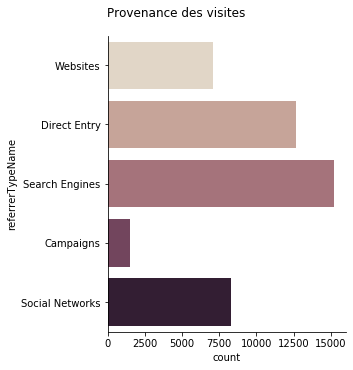

In [230]:
plot = sns.catplot(y="referrerTypeName", kind="count", palette="ch:.25", data=actions)#.set_title('Provenance des visites');
plt.subplots_adjust(top=0.9)
plot.fig.suptitle('Provenance des visites')



Text(0.5, 0.98, "Types d'actions")

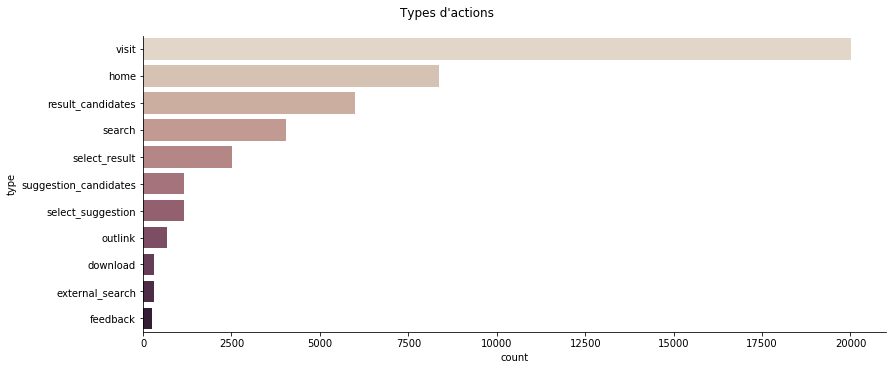

In [233]:
plot = sns.catplot(y="type", kind="count", palette="ch:.25", data=actions, aspect=25.7/10.27, order=['visit', 'home', 'result_candidates', 'search', 'select_result', 'suggestion_candidates', 'select_suggestion', 'outlink', 'download', 'external_search', 'feedback']);
plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Types d'actions")


In [259]:
actions[actions.type == 'search'].shape[0]

4048

In [146]:
visitLength = actions.groupby(["idVisit", "referrerTypeName"]).size().reset_index(name='countActions')

In [150]:
visitLength[visitLength.countActions > 3]

,idVisit,referrerTypeName,countActions
0,87417,Campaigns,30
4,87426,Search Engines,5
6,87428,Search Engines,40
8,87433,Direct Entry,14
9,87434,Search Engines,9
...,...,...,...
5176,95209,Websites,8
5182,95220,Direct Entry,4
5183,95221,Direct Entry,39
5185,95224,Direct Entry,5


In [5]:
actions[actions.type == "select_suggestion"].prefix.apply(lambda x: len(x)).describe()


count    1157.000000
mean       12.334486
std         8.429925
min         3.000000
25%         6.000000
50%        10.000000
75%        16.000000
max        72.000000
Name: prefix, dtype: float64

In [6]:
actions.type.value_counts()

visit                    20017
home                      8362
result_candidates         6001
search                    4048
select_result             2512
select_suggestion         1157
suggestion_candidates     1155
outlink                    672
external_search            316
download                   308
feedback                   257
Name: type, dtype: int64

In [7]:
result_candidates = actions[actions.type == "result_candidates"]
result_candidates[result_candidates["query"] != "undefined"].shape
#result_candidates["query"]

(3744, 22)

In [8]:
actions.shape


(44805, 22)

In [9]:
actions[actions.lastActionTimestamp == actions.lastActionTimestamp.max()]['timestamp']


0     2020-01-06 07:03:51
1     2020-01-06 07:03:52
2     2020-01-06 07:03:52
3     2020-01-06 07:04:01
4     2020-01-06 07:04:02
              ...        
225   2020-01-06 07:59:42
226   2020-01-06 07:59:43
227   2020-01-06 07:59:43
228   2020-01-06 07:59:46
229   2020-01-06 07:59:58
Name: timestamp, Length: 230, dtype: datetime64[ns]

In [10]:
actions[actions.lastActionTimestamp == actions.lastActionTimestamp.min()]['timestamp']

44804   2019-12-23 08:01:22
Name: timestamp, dtype: datetime64[ns]

In [237]:
vl = visitLength[visitLength.countActions<30]

Text(0.5, 0.98, "Nombre d'actions")

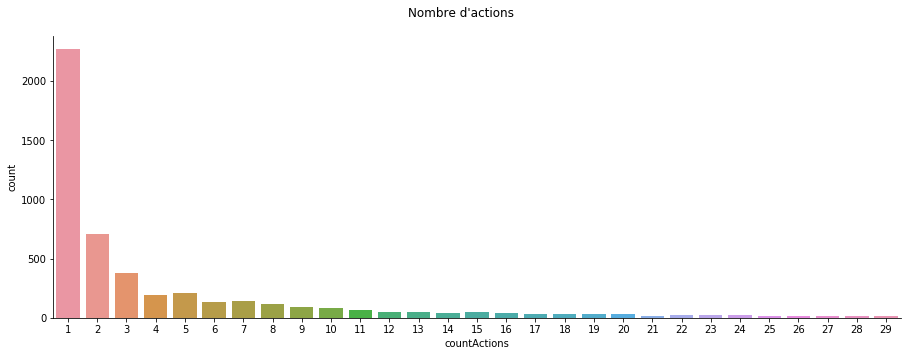

In [238]:
#f, ax = plt.subplots(figsize=(20, 3))
#sns.set(rc={'figure.figsize':(11.1,80.0)})
plot = sns.catplot(x="countActions", kind="count", data=vl, aspect=20.7/8.27);
plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Nombre d'actions")

In [13]:
visitLength[visitLength.countActions == 1].referrerTypeName.value_counts()


Search Engines     990
Direct Entry       922
Social Networks    227
Websites           107
Campaigns           24
Name: referrerTypeName, dtype: int64

In [14]:
visitLength[visitLength.countActions == 2].referrerTypeName.value_counts()



Search Engines     319
Direct Entry       282
Social Networks     75
Websites            25
Campaigns           10
Name: referrerTypeName, dtype: int64

In [15]:
cdt = actions[actions.type == "select_result"]
#cdt[cdt['query'] == "licenciement"].idVisit
cdt.shape


(2512, 22)

In [16]:
visitLength[visitLength.countActions == 7]



,idVisit,referrerTypeName,countActions
74,87542,Search Engines,7
122,87633,Direct Entry,7
155,87703,Websites,7
233,87835,Search Engines,7
287,87930,Search Engines,7
...,...,...,...
4966,94969,Direct Entry,7
4984,94987,Social Networks,7
5067,95081,Search Engines,7
5074,95089,Direct Entry,7


In [17]:
set(actions[actions.type=='select_result'][:20].idVisit.tolist())


{95130, 95159, 95235}

In [63]:
actions[actions.type=='select_suggestion'].sugg_selection.value_counts()[:20]



congés payés                      99
rupture conventionnelle cdi       83
congés sans solde                 80
période d'essai                   54
congés payés acquisition          52
préavis cdd                       48
congés payés et fractionnement    46
indemnités de licenciement        42
congés payés et maladie           41
licenciement                      41
licenciement économique           34
durée du préavis                  32
licenciement abusif               30
démission                         29
cse entreprise                    27
heures supplémentaires            27
congé maternité                   25
harcèlement moral                 25
convention collective             24
congé parental                    23
Name: sugg_selection, dtype: int64

In [21]:
actions.type.unique()


array(['suggestion_candidates', 'result_candidates', 'search',
       'select_result', 'visit', 'home', 'select_suggestion', 'feedback',
       'download', 'external_search', 'outlink'], dtype=object)

In [22]:
# get id visits where contains at least a select search result or a select suggestion
actions[(actions.type == "select_result") | (actions.type == "select_suggestion")].idVisit.unique()

array([95159, 95235, 95130, ..., 87451, 87448, 87445])

In [23]:
actions.idVisit.unique().shape

(5194,)

In [36]:
id_results = actions[actions.type == "result_candidates"].idVisit.unique()

In [37]:
id_select = actions[actions.type == "select_result"].idVisit.unique()

In [40]:
id_results[:10]

array([95159, 95235, 95130, 95221, 95146, 95151, 95183, 95232, 95177,
       95224])

In [41]:
id_select[:10]

array([95159, 95235, 95130, 95221, 95146, 95151, 95177, 95224, 95150,
       95190])

In [52]:
actions[actions.type == "select_result"].res_selection[:1]

3    {'url': '/fiche-ministere-travail/la-demission#Faut-il-respecter-un-preavis', 'algo': 'pre-qualified'}
Name: res_selection, dtype: object

In [34]:
id_results.shape

NameError: name 'id_results' is not defined

## Suggestions

In [266]:
# number of suggestions selection vs number of searches

In [286]:
n_unique_suggestions = actions[(actions.type == "select_suggestion")][["sugg_selection", "idVisit", "type"]].drop_duplicates()


In [287]:
# isolate unique searches (to avoid 'return to search')
n_unique_searches = actions[(actions.type == "search")][["query", "idVisit", "type"]].drop_duplicates()
# remove random to mark the positive suggestions and only get right number or non suggested
non_suggested = n_unique_searches[n_unique_suggestions.shape[0]:]
# TODO isolate actual searches without suggestion (not only the count)

/Users/remim/dev/cdtn/.python-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Text(0.5, 0.98, 'Nombre de recherches directes & recherches suggérées')

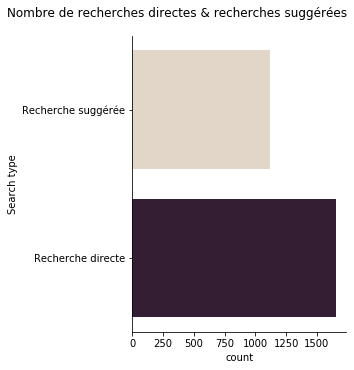

In [296]:
sugg_data = pd.concat([n_unique_suggestions, non_suggested])
sugg_data['Search type'] = sugg_data.type.apply(lambda x : 'Recherche suggérée' if x != 'search' else 'Recherche directe')
plot = sns.catplot(y="Search type", kind="count", palette="ch:.25", data=sugg_data);
plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Nombre de recherches directes & recherches suggérées")

In [297]:
# prefix size

Text(0.5, 0.98, 'Longueur du prefix de suggestion.')

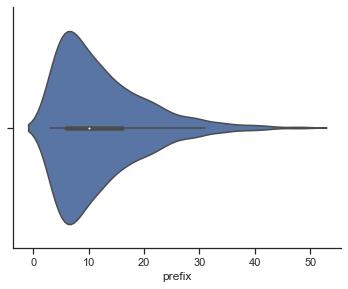

In [321]:
prefix_size = pd.DataFrame(actions[actions.type=='select_suggestion'].prefix.apply(lambda x : len(x)))
prefix_size = prefix_size[prefix_size<50]
sns.catplot(x="prefix", kind="violin", data=prefix_size);
plt.subplots_adjust(top=0.8)
plot.fig.suptitle("Longueur du prefix de suggestion.")

## Results selection : check number of : pre-qualified / semantic / fulltext

In [375]:
def get_type(element, keyword='url'):
    #parsed = json.loads(element)
    if 'algo' in element:
        return element['algo']
    elif element[keyword].startswith('http'):
        return 'http'
    else:
        # special case for theme search
        t = element[keyword][1:element[keyword].rfind('/')]
        if t == 'fiche-service-public' or t == 'fiche-ministere-travail' :
            return 'theme'
        else:
            return t
        
select_actions = actions[(actions.type == "select_result") & (actions.query != "undefined")]
selection_types = select_actions.res_selection.apply(lambda e : get_type(e))

Text(0.5, 0.98, 'Répartition des sélections des résultats du moteur de recherche.')

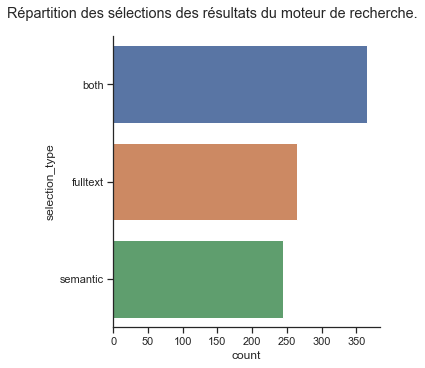

In [376]:
st_df = pd.DataFrame({'selection_type':selection_types})
st_df["search_engine"] = st_df['selection_type'].apply(lambda x : 'search engine' if x in ['fulltext', 'both', 'semantic'] else x)

plot = sns.catplot(y='selection_type', kind="count", data=st_df, order=['both', 'fulltext', 'semantic']);
                    #order=['pre-qualified', 'search engine'])

plt.subplots_adjust(top=0.9)
#plot.fig.suptitle("Répartition des selections pre-qualified / moteur de recherche.")
plot.fig.suptitle("Répartition des sélections des résultats du moteur de recherche.")

## Number of results in candidates for each type

In [330]:
def read_candidates(cands):
    docs = cands['documents']
    themes = cands['themes']
    
    doc_types = [get_type(d, 'slug') for d in docs]
    theme_types = [get_type(t, 'slug') for t in themes]
    
    preq = 'pre-qualified' in doc_types
    n_docs = len(doc_types)
    
    return [preq, n_docs, doc_types, theme_types]
    
result_candidates_all = actions[actions.type == "result_candidates"]    
result_candidates = result_candidates_all[result_candidates_all['query'] != 'undefined']
parsed_candidates = result_candidates['result_candidates'].apply(lambda cands : read_candidates(cands))


In [331]:
result_candidates_all.shape
result_candidates.shape

(3744, 22)

In [332]:
parsed_candidates_df = pd.DataFrame(parsed_candidates.tolist(), columns = ['isPreq', 'nDoc', 'doc_types', 'theme_types'])

In [333]:
parsed_candidates_df[parsed_candidates_df.theme_types.apply(lambda n : len(n)) == 0].shape

(122, 4)

Text(0.5, 0.98, 'Proportion de decherches prequalifiées')

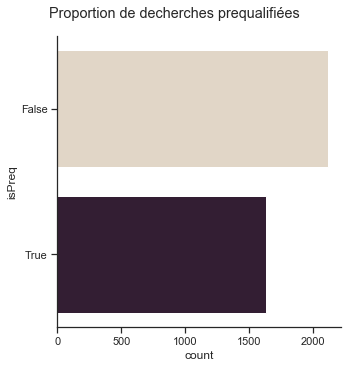

In [337]:
parsed_candidates_df.isPreq

plot = sns.catplot(y="isPreq", kind="count", palette="ch:.25", data=parsed_candidates_df);
plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Proportion de recherches prequalifiées")

In [335]:
#actions[actions.type == "result_candidates"][['type', 'query', 'result_candidates']][:30]

In [402]:
preq_length = parsed_candidates_df[parsed_candidates_df.isPreq].doc_types.apply(lambda x : len(x))

In [407]:
preq_length_df = pd.DataFrame({'pre-qualified-n-results':preq_length})

Text(0.5, 0.98, 'Nombre de résultats pour les recherches préqualifiées.')

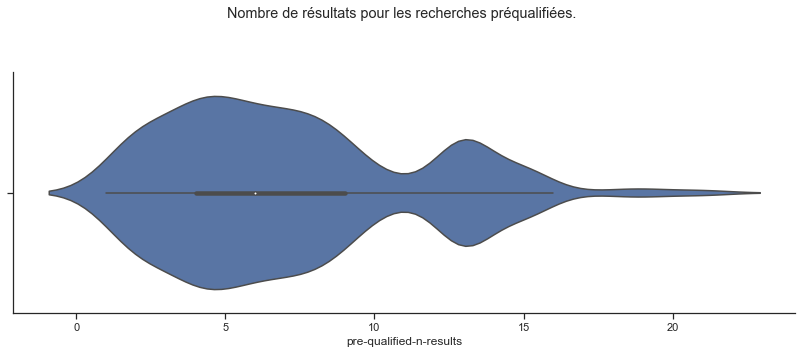

In [412]:
plot = sns.catplot(x="pre-qualified-n-results", kind="violin", data=preq_length_df, aspect=18.7/8.27);
plt.subplots_adjust(top=0.8)
plot.fig.suptitle("Nombre de résultats pour les recherches préqualifiées.")

## check number of results with less than X results

## check feedback

Text(0.5, 0.98, 'Retours explicites des utilisateurs.')

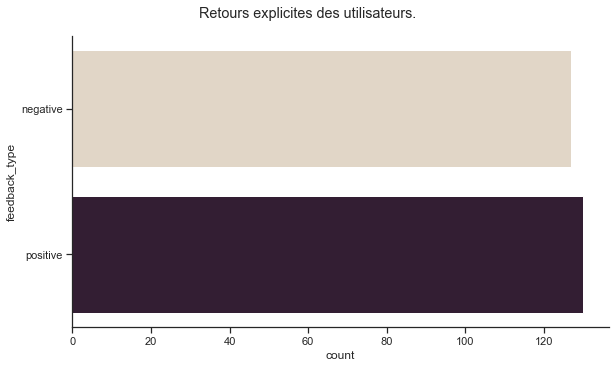

In [421]:
actions[actions.type == 'feedback']
plot = sns.catplot(y="feedback_type", kind="count", palette="ch:.25", data=actions[actions.type == 'feedback'], aspect=5.7/3.27);
plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Retours explicites des utilisateurs.")

In [429]:
neg_visits = actions[actions.feedback_type == 'negative'].idVisit.unique()
actions[actions.idVisit == neg_visits[32]]

,referrerName,referrerTypeName,type,idVisit,suggestion_candidates,@timestamp,timeSpent,serverTimePrettyFirstAction,timestamp,lastActionTimestamp,...,serverTimePretty,lastActionDateTime,query,result_candidates,res_selection,subtitle,prefix,sugg_selection,feedback_type,visited
8997,Google,Search Engines,home,93926,NaN,2020-01-03T15:40:13.000Z,9.0,07:40:13,2020-01-03 15:40:13,1578066040,...,"Jan 3, 2020 07:40:13",2020-01-03 15:40:40,NaN,NaN,NaN,https://code.travail.gouv.fr/,NaN,NaN,NaN,NaN
8998,Google,Search Engines,select_suggestion,93926,NaN,2020-01-03T15:40:22.000Z,0.0,07:40:13,2020-01-03 15:40:22,1578066040,...,"Jan 3, 2020 07:40:22",2020-01-03 15:40:40,NaN,NaN,NaN,NaN,cont,contrat cdi,NaN,NaN
8999,Google,Search Engines,suggestion_candidates,93926,"[contrat cdd, contrat cdi, contenu d'un cdi, contester un blâme, contrat d'apprentissage cdd]",2020-01-03T15:40:22.000Z,1.0,07:40:13,2020-01-03 15:40:22,1578066040,...,"Jan 3, 2020 07:40:22",2020-01-03 15:40:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9000,Google,Search Engines,search,93926,NaN,2020-01-03T15:40:23.000Z,0.0,07:40:13,2020-01-03 15:40:23,1578066040,...,"Jan 3, 2020 07:40:23",2020-01-03 15:40:40,contrat cdi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9001,Google,Search Engines,result_candidates,93926,NaN,2020-01-03T15:40:23.000Z,3.0,07:40:13,2020-01-03 15:40:23,1578066040,...,"Jan 3, 2020 07:40:23",2020-01-03 15:40:40,contrat cdi,"{'documents': [{'slug': '/fiche-service-public/conclusion-dun-contrat-de-travail-a-duree-indeterminee-cdi', 'algo': 'pre-qualified'}, {'slug': '/fiche-ministere-travail/le-contrat-de-travail-a-duree-indeterminee-cdi#Quel-est-le-contenu-du-CDI', 'algo': 'pre-qualified'}, {'slug': '/fiche-ministere-travail/le-contrat-de-travail-a-duree-indeterminee-cdi#Dans-quels-cas-un-CDI-doit-il-etre-conclu', 'algo': 'pre-qualified'}, {'slug': '/fiche-ministere-travail/le-contrat-de-travail-a-duree-indeterminee-cdi#Quelle-forme-doit-revetir-le-CDI', 'algo': 'pre-qualified'}, {'slug': '/fiche-service-public/quest-ce-quun-contrat-de-travail-a-duree-indeterminee-cdi-interimaire', 'algo': 'pre-qualified'}, {'slug': '/fiche-ministere-travail/le-contrat-a-duree-indeterminee-de-chantier-ou-doperation#Qu-est-ce-qu-un-contrat-de-chantier-ou-d-operation', 'algo': 'pre-qualified'}, {'slug': '/fiche-ministere-travail/le-contrat-de-travail-a-duree-indeterminee-cdi#Comment-le-CDI-peut-il-prendre-fin', 'algo': 'pre-qualified'}, {'slug': '/fiche-service-public/dans-quels-cas-un-cdd-est-il-requalifie-en-cdi', 'algo': 'pre-qualified'}, {'slug': '/fiche-service-public/le-contrat-de-travail-est-il-obligatoirement-ecrit', 'algo': 'pre-qualified'}], 'themes': [{'slug': '/themes/121-cdi', 'algo': 'semantic'}, {'slug': '/themes/122-cdd', 'algo': 'fulltext'}, {'slug': '/themes/1-embauche-et-contrat-de-travail', 'algo': 'semantic'}, {'slug': '/themes/124-contrat-dapprentissage', 'algo': 'fulltext'}], 'articles': [{'slug': '/code-du-travail/l1221-1', 'algo': 'pre-qualified'}, {'slug': '/code-du-travail/l1221-2', 'algo': 'pre-qualified'}, {'slug': '/code-du-travail/l1221-3', 'algo': 'pre-qualified'}, {'slug': '/code-du-travail/l1242-17'}, {'slug': '/code-du-travail/l1243-11'}]}",NaN,NaN,NaN,NaN,NaN,NaN
9002,Google,Search Engines,select_result,93926,NaN,2020-01-03T15:40:26.000Z,0.0,07:40:13,2020-01-03 15:40:26,1578066040,...,"Jan 3, 2020 07:40:26",2020-01-03 15:40:40,NaN,NaN,"{'url': '/fiche-service-public/conclusion-dun-contrat-de-travail-a-duree-indeterminee-cdi', 'algo': 'pre-qualified'}",NaN,NaN,NaN,NaN,NaN
9003,Google,Search Engines,visit,93926,NaN,2020-01-03T15:40:26.000Z,14.0,07:40:13,2020-01-03 15:40:26,1578066040,...,"Jan 3, 2020 07:40:26",2020-01-03 15:40:40,NaN,NaN,NaN,https://code.travail.gouv.fr/fiche-service-public/conclusion-dun-contrat-de-travail-a-duree-indeterminee-cdi,NaN,NaN,NaN,NaN
9004,Google,Search Engines,feedback,93926,NaN,2020-01-03T15:40:40.000Z,NaN,07:40:13,2020-01-03 15:40:40,1578066040,...,"Jan 3, 2020 07:40:40",2020-01-03 15:40:40,NaN,NaN,NaN,NaN,NaN,NaN,negative,/fiche-service-pu

## get most frequent queries (more than 3) to add to suggestions

In [385]:
n_unique_searches['query'].apply(lambda x: x.lower()).value_counts()[:30]

congés payés                             78
undefined                                43
licenciement                             34
rupture conventionnelle cdi              24
période d'essai                          23
préavis                                  19
congés sans solde                        19
heures supplémentaires                   19
apprentissage                            18
rupture conventionnelle                  18
indemnité de licenciement                17
cdd                                      17
démission                                16
cse                                      14
temps partiel                            14
contrat de travail                       12
licenciement abusif                      12
préavis cdd                              11
congés payés et maladie                  11
durée du préavis                         11
discrimination                           11
rtt                                      11
organisme professionnel de préve

# Print ranks for most frequent suggestion selected

/Users/remim/dev/cdtn/.python-env/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


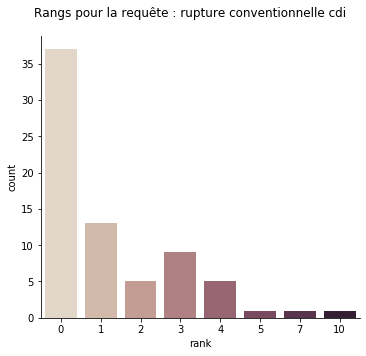

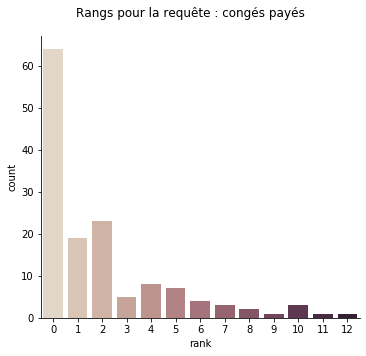

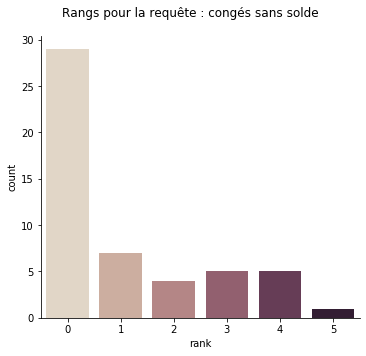

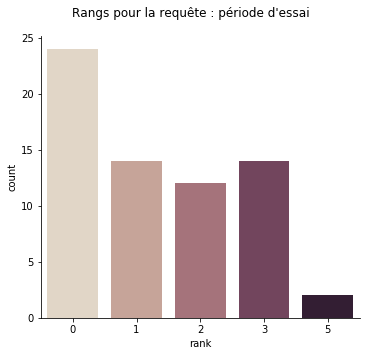

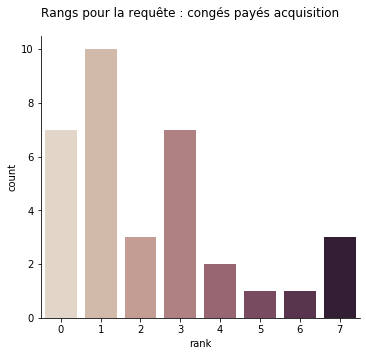

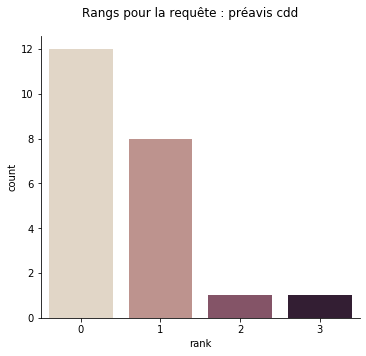

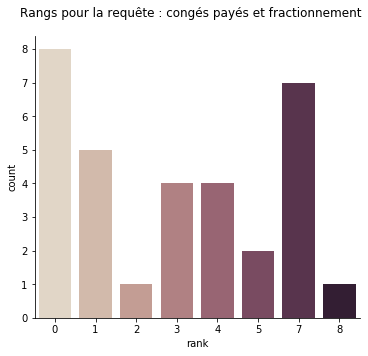

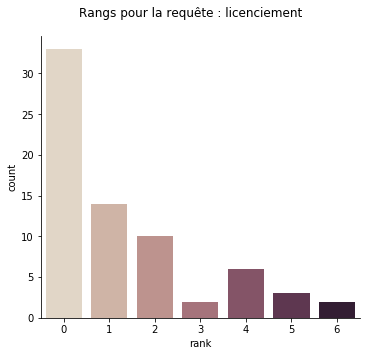

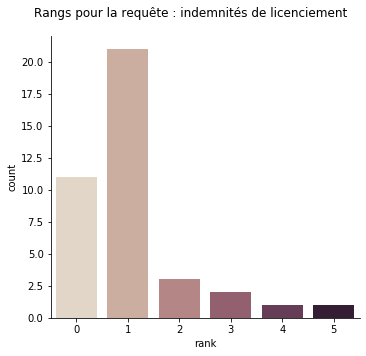

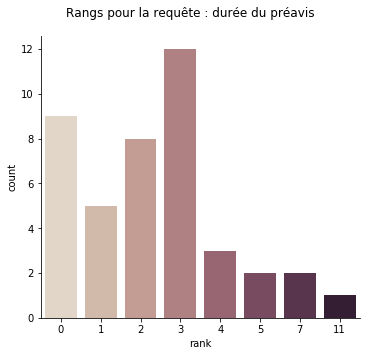

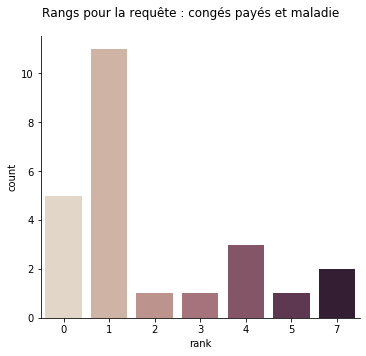

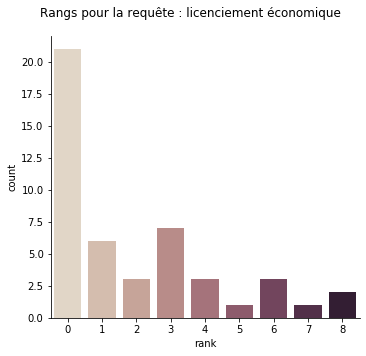

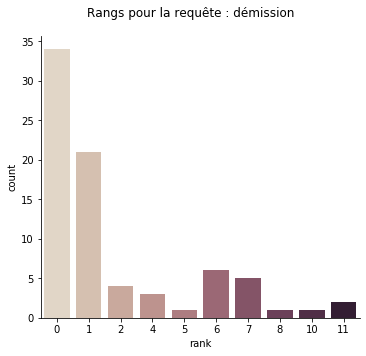

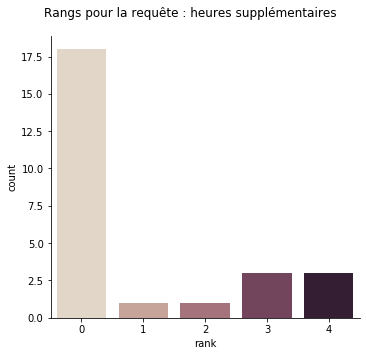

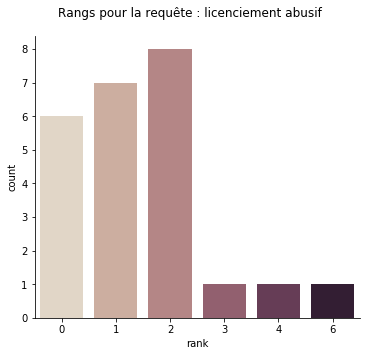

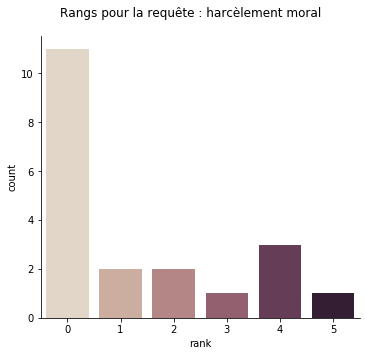

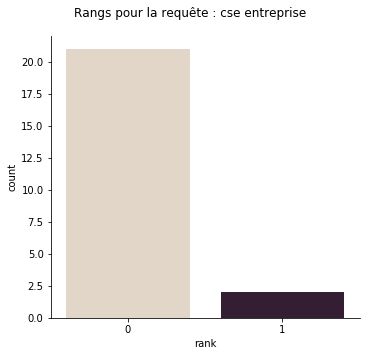

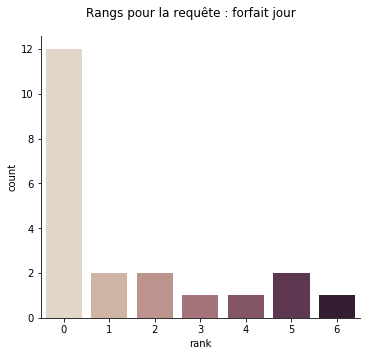

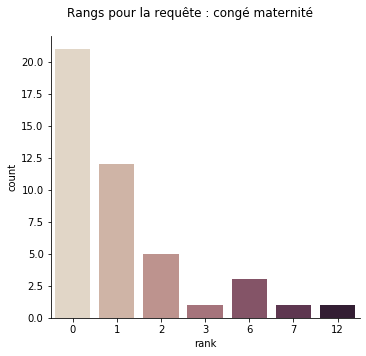

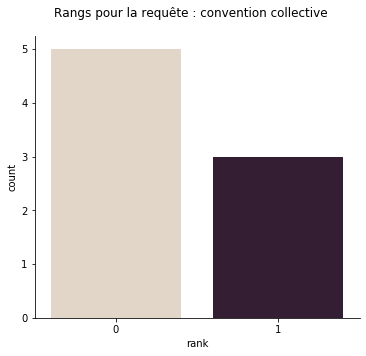

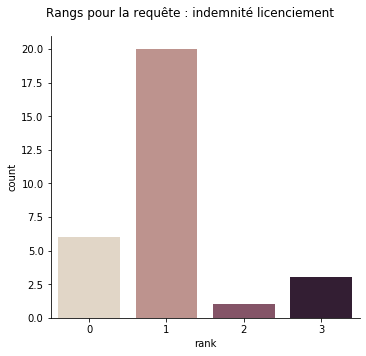

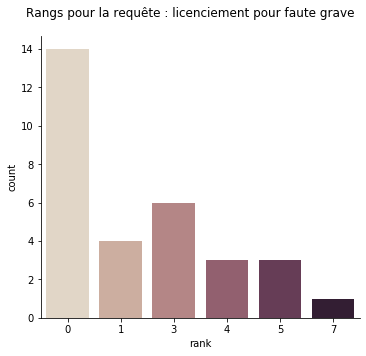

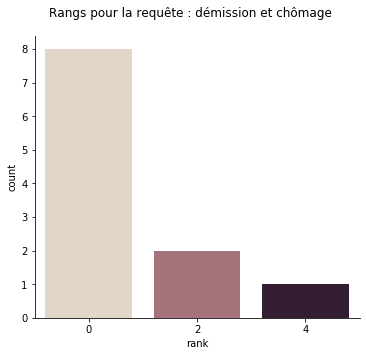

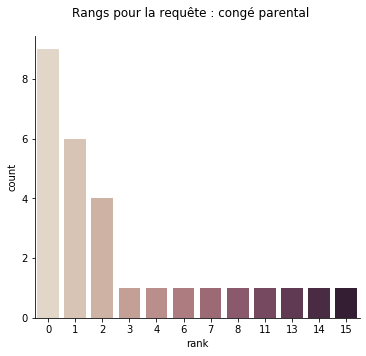

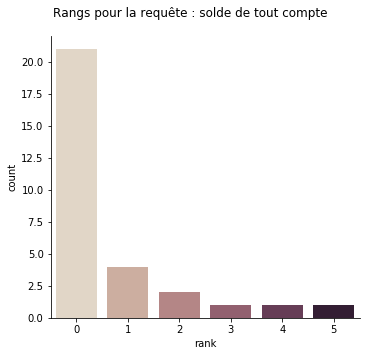

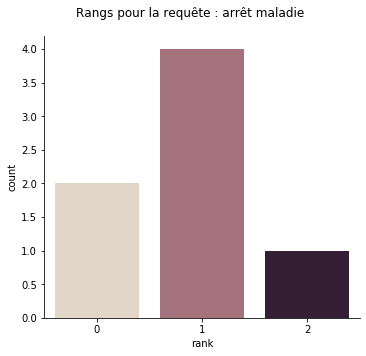

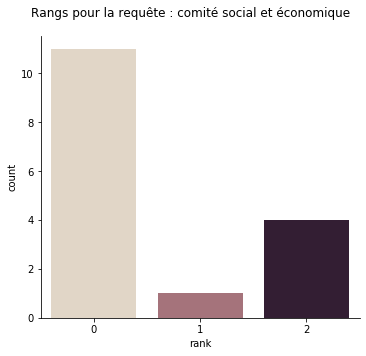

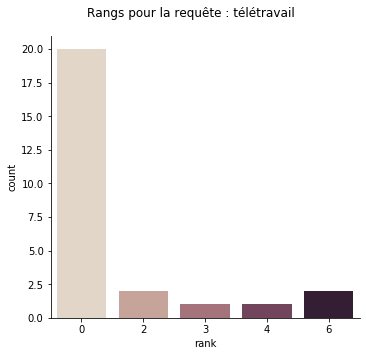

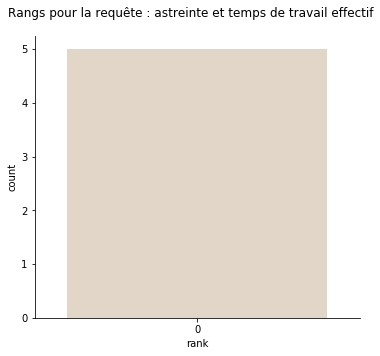

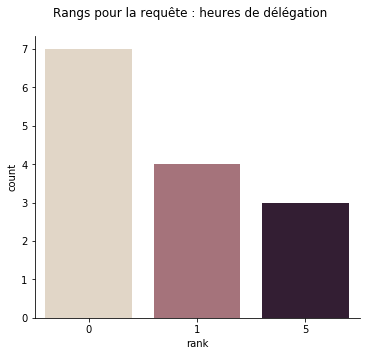

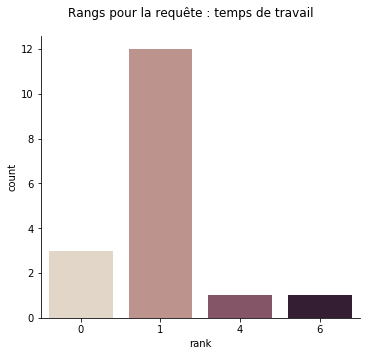

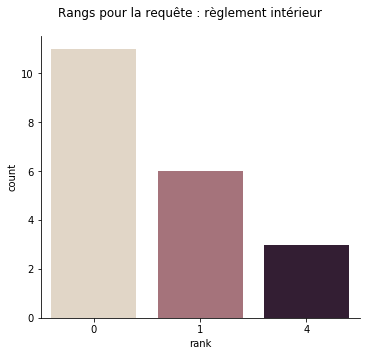

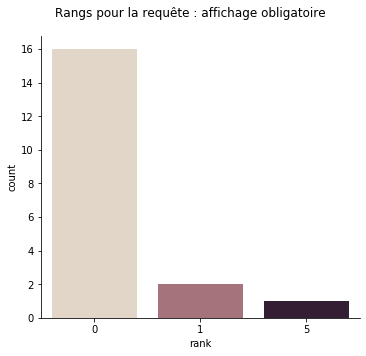

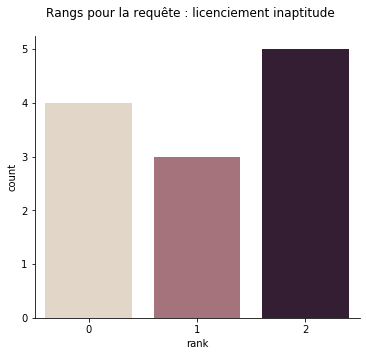

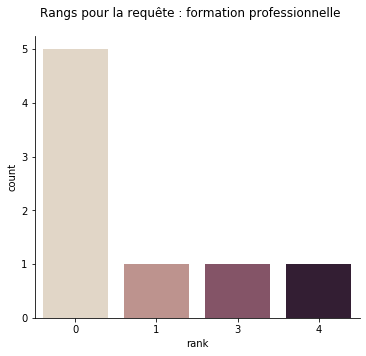

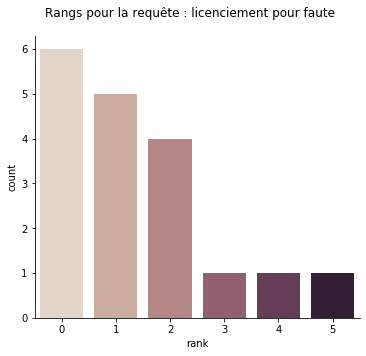

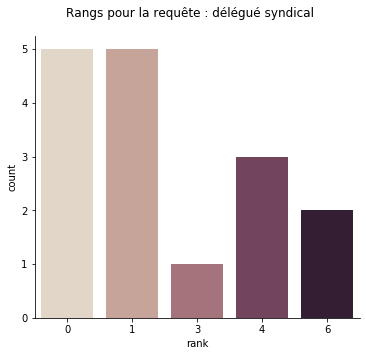

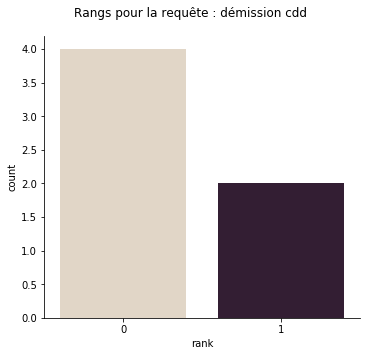

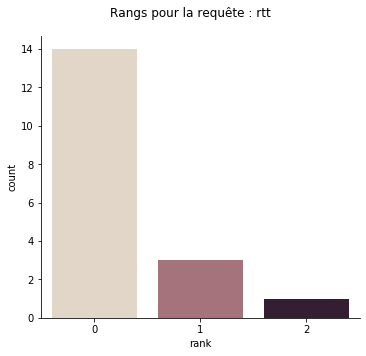

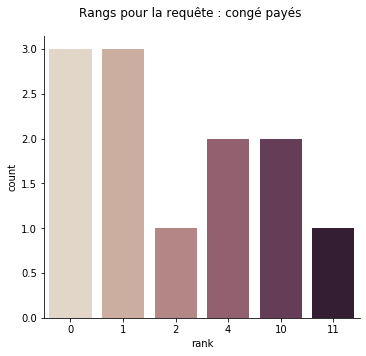

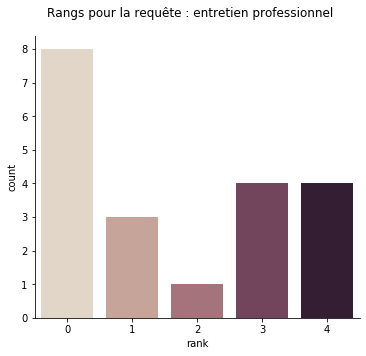

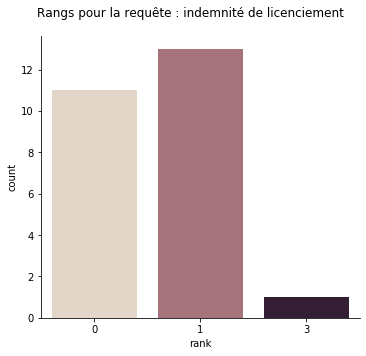

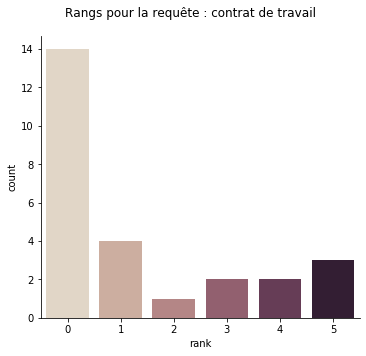

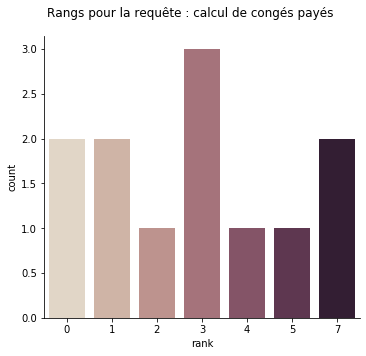

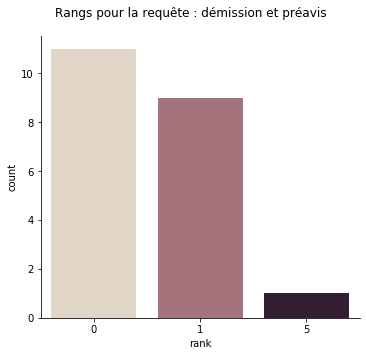

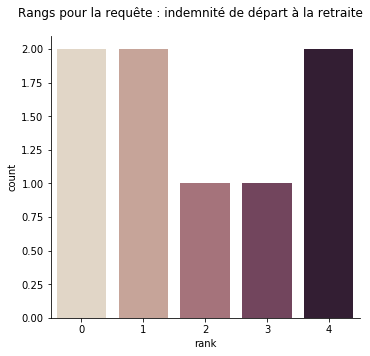

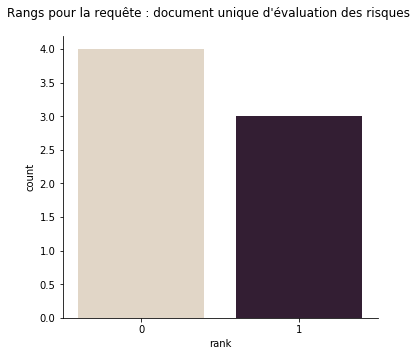

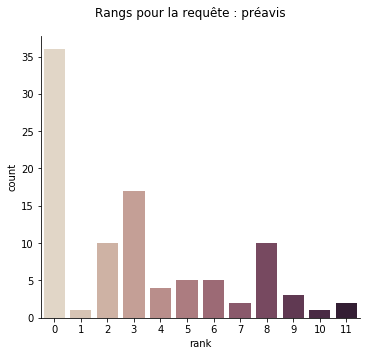

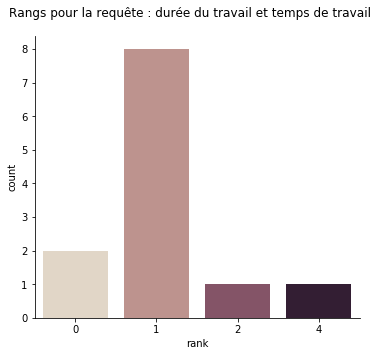

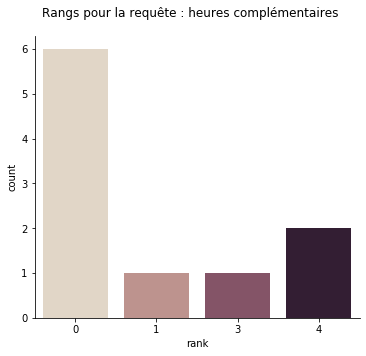

In [47]:
for e in actions[actions.type=='select_suggestion'].sugg_selection.value_counts()[:50].index.tolist():
    print_rangs(e)

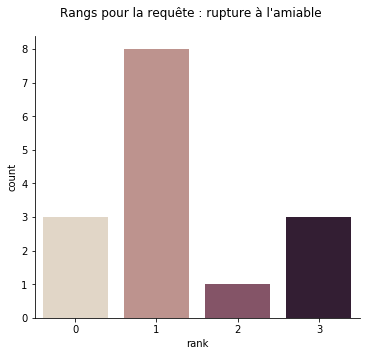

In [208]:
print_rangs("rupture à l'amiable")

In [ ]:
# most frequent queries without hit
for g, rows in df_searches[df_searches['rank'] == -1].groupby(["query"]):
    n = rows.shape[0]
    if (n > 10):
        print(f'{g} -> {n}')

In [41]:
df_searches.groupby(["query"])

In [57]:
# test : 
# reordonner les resultats DF de maniere factice et comparer la difference entre les scores

In [ ]:
import requests

params = {
    "y_pred" : ["b", "a", "c", "w", "k","e"], # y_pred (array): list of documents id predicted by the system
    "y_true" : ["a", "b", "c", "e"], # y_true (array): documents id scored by humans sorted from most relevant to least relevant
    "y_score" : {
        "a":15,
        "b":3,
        "c":2,
        "e":2
            }, # y_score is a dict {"doc_id":"score"} of documents assigned as relevant y humans with the associated scores (ordered internally)
    "method" : "all", # one of ["precision", "recall", "dcg", "mrr", "all"]
    "k": 4 # k integer preferaly =< to length(y_pred)
}

r = requests.post("http://localhost:4545/api/score", json = params)
r.json()